## Objective
Run algorithm on spikeinterface recording

si_rec12.ipynb -> si_rec13.ipynb: Final version of code for final draft of first RT-Sort manuscript

## Globals setup

In [1]:
%env MKL_NUM_THREADS=1
%env NUMEXPR_NUM_THREADS=1
%env OMP_NUM_THREADS=1

env: MKL_NUM_THREADS=1
env: NUMEXPR_NUM_THREADS=1
env: OMP_NUM_THREADS=1


In [2]:
%load_ext autoreload

In [3]:
from copy import deepcopy
from importlib import reload
from multiprocessing import Pool
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

# Only for testing
from diptest import diptest
%autoreload 2
from src import utils, recording
from src.run_alg import si_rec13 as F  # This forces you to manually reload every time modification happens (prevents forgetfulness errors)
from src.sorters.base import Unit

In [4]:
RECORDING = utils.rec_si().rec_raw
RECORDING.set_channel_gains(0.195)
RECORDING.set_channel_offsets(0.0)
CHANS_RMS = utils.chans_rms_si()

SAMP_FREQ = round(RECORDING.get_sampling_frequency() / 1000)  # kHz

NUM_ELECS = RECORDING.get_num_channels()
ELEC_LOCS = RECORDING.get_channel_locations()

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


Recording does not have scaled traces. Setting gain to 0.195


In [5]:
TRAINING_MS = (0, 5*60*1000)  # 0 minto 5 min in recording (in ms)
TESTING_MS = (5*60*1000, 10*60*1000)  # 5 min to 10 min in recording (in ms)
TRACES_TRAINING_MS = (50, 5*60*1000)  # Rel to scaled_traces  (skip first 50ms since needed to median noise estimator)

In [6]:
ROOT_PATH_MODEL = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/dl_model/240318") # Where model outputs are saved
MODEL_PATH = Path("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318/c/240318_165245_967091") # Path to model
# ROOT_PATH_MODEL = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/dl_model/240318_speed_test_240328") # Where model outputs are saved
# MODEL_PATH = Path("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/240318/c/240318_165245_967091") # Path to model
STRINGENT_THRESH = 0.175
STRINGENT_THRESH_LOGIT = F.sigmoid_inverse(STRINGENT_THRESH)
LOOSE_THRESH = 0.075
LOOSE_THRESH_LOGIT = F.sigmoid_inverse(LOOSE_THRESH)

INFERENCE_SCALING_NUMERATOR = None  # 15.4  # 15.4 is the value, but DO NOT use it for the spikeinterface real neuropixels recording

FRONT_BUFFER = round(2*SAMP_FREQ)
OUTPUT_WINDOW_HALF_SIZE = round(3*SAMP_FREQ)
PRE_MEDIAN_FRAMES = round(50 * SAMP_FREQ)

## No user inputs below
ROOT_PATH_MODEL.mkdir(exist_ok=True, parents=True)

SCALED_TRACES_PATH = ROOT_PATH_MODEL / "scaled_traces.npy"

MODEL_TRACES_PATH = ROOT_PATH_MODEL / "model_traces.npy"
MODEL_OUTPUTS_PATH = ROOT_PATH_MODEL / "model_outputs.npy" 

ALL_CROSSINGS_PATH  = ROOT_PATH_MODEL / "all_crossings.npy"
ELEC_CROSSINGS_IND_PATH = ROOT_PATH_MODEL / "elec_crossings_ind.npy"

In [7]:
F.RECORDING = RECORDING
F.NUM_ELECS = NUM_ELECS
F.ELEC_LOCS = ELEC_LOCS
F.SAMP_FREQ = SAMP_FREQ
F.FRONT_BUFFER = FRONT_BUFFER
F.INFERENCE_SCALING_NUMERATOR = INFERENCE_SCALING_NUMERATOR
F.PRE_MEDIAN_FRAMES = PRE_MEDIAN_FRAMES

In [8]:
# For RT-Sort manuscript: measure time to detect sequences
import time

class Stopwatch:
    def __init__(self):
        self.duration = 0
        self.start_time = 0
    def start(self):
        self.start_time = time.time()
    def stop(self):
        stop_time = time.time()
        self.duration += stop_time - self.start_time

stopwatch = Stopwatch()

In [9]:
stopwatch.start()

# No user inputs here. Run after running DL model
ALL_CLOSEST_ELECS = []
for elec in range(NUM_ELECS):
    elec_ind = []
    dists = []
    x1, y1 = ELEC_LOCS[elec]
    for elec2 in range(RECORDING.get_num_channels()):
        if elec == elec2:
            continue
        x2, y2 = ELEC_LOCS[elec2]
        dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        elec_ind.append(elec2)
    order = np.argsort(dists)
    ALL_CLOSEST_ELECS.append(np.array(elec_ind)[order])   
# 
TRACES = np.load(MODEL_TRACES_PATH, mmap_mode="r")
OUTPUTS = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")
ALL_CROSSINGS = np.load(ALL_CROSSINGS_PATH, allow_pickle=True)
ELEC_CROSSINGS_IND = np.load(ELEC_CROSSINGS_IND_PATH, allow_pickle=True)

ALL_CROSSINGS = [tuple(cross) for cross in ALL_CROSSINGS]
ELEC_CROSSINGS_IND = [tuple(ind) for ind in ELEC_CROSSINGS_IND]  # [(elec's cross times ind in all_crossings)]

stopwatch.stop()

In [91]:
# Set global variables in .py
reload(F)

F.RECORDING = RECORDING
F.MEA = False
F.STRINGENT_THRESH = STRINGENT_THRESH
F.STRINGENT_THRESH_LOGIT = STRINGENT_THRESH_LOGIT
F.LOOSE_THRESH = LOOSE_THRESH
F.LOOSE_THRESH_LOGIT = LOOSE_THRESH_LOGIT
F.INFERENCE_SCALING_NUMERATOR = INFERENCE_SCALING_NUMERATOR

# F.CHANS_RMS = CHANS_RMS
F.SAMP_FREQ = SAMP_FREQ
F.NUM_ELECS = NUM_ELECS
F.ELEC_LOCS = ELEC_LOCS

F.ALL_CLOSEST_ELECS = ALL_CLOSEST_ELECS

F.FRONT_BUFFER = FRONT_BUFFER
F.OUTPUT_WINDOW_HALF_SIZE = OUTPUT_WINDOW_HALF_SIZE

F.N_BEFORE = F.N_AFTER = round(0.5 * SAMP_FREQ)  # Window for looking for electrode codetections
F.MIN_ELECS_FOR_ARRAY_NOISE = max(100, round(0.1 * NUM_ELECS))
F.MIN_ELECS_FOR_SEQ_NOISE = max(50, round(0.05 * NUM_ELECS))
F.PRE_MEDIAN_FRAMES = PRE_MEDIAN_FRAMES

F.MIN_ACTIVITY = 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000

# If doing on new recording, these should be set after ## Full run - DL model
F.TRACES = TRACES
F.OUTPUTS = OUTPUTS
F.ALL_CROSSINGS = ALL_CROSSINGS
F.ELEC_CROSSINGS_IND = ELEC_CROSSINGS_IND


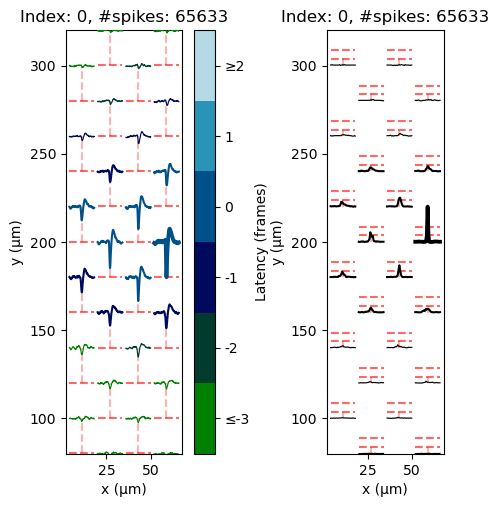

In [11]:
# Plot all crossings on an elec as sanity check
elec = 17
spikes = [ALL_CROSSINGS[idx][1] for idx in ELEC_CROSSINGS_IND[elec]]
F.plot_spikes(spikes, elec)
plt.show()

## Development

In [18]:
# form_from_root
root_elec=1

time_frame=TRAINING_MS
coc_clusters = F.form_coc_clusters(root_elec, time_frame, 
                                   verbose=True)

Starting with elec 1, loc: [59. 40.]

Finding coocurrences


100%|██████████| 13779/13779 [00:06<00:00, 2205.93it/s]


2403 cocs total

Unimodal amp/median with p-value: 0.000

Comparing to elec 3, loc: [43. 60.]
Found 2 clusters
2095 cocs remaining

Comparing to elec 2, loc: [27. 40.]
Found 1 clusters
1058 cocs remaining

Comparing to elec 5, loc: [59. 80.]
Found 2 clusters
478 cocs remaining

Cluster 2: p-val=0.0690
Split cluster 2 into 2 clusters

Total: 5 clusters


In [ ]:
F.setup_coc_clusters(coc_clusters, verbose=True)

100%|██████████| 18/18 [00:19<00:00,  1.08s/it]


In [45]:
merged_clusters = F.merge_coc_clusters(coc_clusters, verbose=True)


Merged 14 with 2
Latency diff: 0.50. Amp median diff: 0.14
Amp dist p-value 0.4048
#spikes:
Merge base: 66, Add: 21, Overlaps: 0
After merging: 87

Merged 0 with 12
Latency diff: 0.42. Amp median diff: 0.16
Amp dist p-value 0.6439
#spikes:
Merge base: 108, Add: 568, Overlaps: 0
After merging: 676

Merged 8 with 13
Latency diff: 0.24. Amp median diff: 0.20
Amp dist p-value 0.6202
#spikes:
Merge base: 151, Add: 741, Overlaps: 0
After merging: 889

Merged 15 with 3
Latency diff: 0.64. Amp median diff: 0.13
Amp dist p-value 0.7671
#spikes:
Merge base: 73, Add: 57, Overlaps: 0
After merging: 130

Merged 1 with 5
Latency diff: 1.01. Amp median diff: 0.08
Amp dist p-value 0.6999
#spikes:
Merge base: 32, Add: 54, Overlaps: 0
After merging: 86

Merged 16 with 6
Latency diff: 0.70. Amp median diff: 0.14
Amp dist p-value 0.9943
#spikes:
Merge base: 527, Add: 119, Overlaps: 0
After merging: 645

Merged 7 with [0, 12]
Latency diff: 0.13. Amp median diff: 0.28
Amp dist p-value 0.8692
#spikes:
Merge

In [14]:
F.setup_coc_clusters(merged_clusters, verbose=True)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:22<00:00,  2.07s/it]


In [29]:
F.assign_spikes_gpu(merged_clusters, TRAINING_MS)

100%|██████████| 58804/58804 [00:54<00:00, 1080.51it/s]


In [71]:
F.assign_spikes(coc_clusters, time_frame, verbose=True)
print(len(coc_clusters))
coc_clusters = [c for c in coc_clusters if len(c._spike_train) >= 3]
print(len(coc_clusters))

100%|██████████| 4702764/4702764 [00:25<00:00, 181747.61it/s]

5
4


In [ ]:
merged_clusters = F.merge_coc_clusters(coc_clusters, verbose=True)

In [ ]:
use_formation_spike_train = False
use_filt = False  # If True, amp in footprint may not match histogram (histogram does not use filtered traces)

for i, cluster in enumerate(coc_clusters):    
    F.plot_elec_probs(cluster, idx=i, use_formation_spike_train=use_formation_spike_train, use_filt=use_filt)
    plt.show()
            
    # amp_medians = F.get_amp_medians(cluster, n_cocs=None, use_formation_spike_train=use_formation_spike_train).flatten()
    # plt.hist(amp_medians, bins=30)
    # plt.show()
    
    # print(f"dip p-val: {diptest(amp_medians)[1]:.3f}")

In [ ]:
np.random.seed(1)
seq = merged_clusters[3]
for spike in np.random.choice(seq.spike_train, 20)[10:]:
    F.plot_spikes([spike], root_elec)
    plt.show()

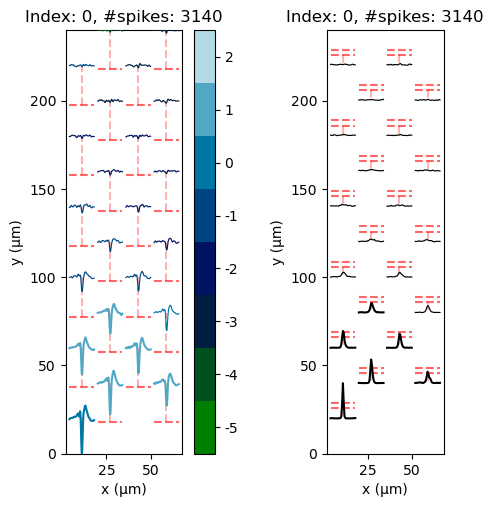

In [44]:
# cluster = root_elec_to_clusters[0][-1]
cluster = test
F.plot_elec_probs(cluster)
plt.show()

# plt.hist(cluster.every_elec_prob[0, :])
# plt.show()

Max root dist: 25.61
Inner overlap: 6
Loose overlap: 7, 0.70
Latency diff: 0.41
Amp diff : 0.46
2Z-score: 0.91


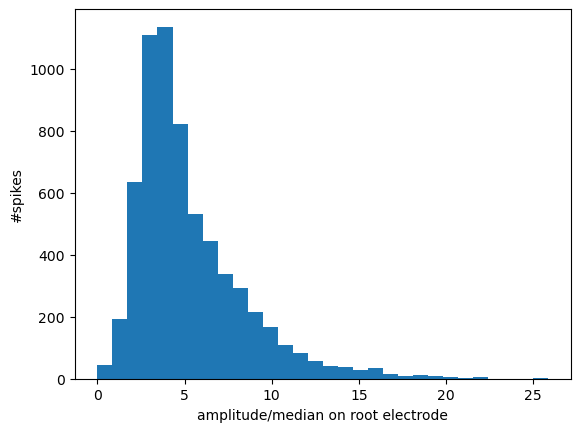

2Z-score: 2.80


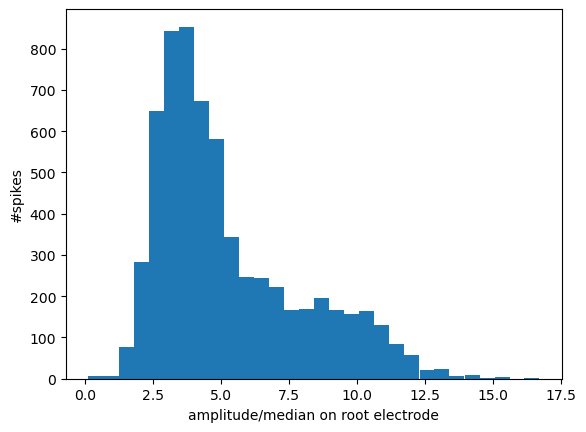

In [103]:
## Examine merge scores of seq pair
cluster_i = trained_sequences[8]
cluster_j = trained_sequences[9]

# cluster_i = root_elec_to_clusters[1][0]
# cluster_j = root_elec_to_clusters[1][1]

# F.plot_elec_probs(cluster_i)
# plt.show()
# F.plot_elec_probs(cluster_j)
# plt.show()

# amp_kwargs, prob_kwargs = F.plot_elec_probs(cluster_j)
# plt.show()
# F.plot_elec_probs(cluster_i, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
# plt.show()

max_dist = 0
for root_i in cluster_i.root_elecs:
    for root_j in cluster_j.root_elecs:
        max_dist = max(max_dist, F.calc_elec_dist(root_i, root_j))
print(f"Max root dist: {max_dist:.2f}")

total_loose = len(set(cluster_i.loose_elecs).union(cluster_j.loose_elecs))
num_loose_overlaps = len(set(cluster_i.loose_elecs).intersection(cluster_j.loose_elecs))
num_inner_loose_overlaps = len(set(cluster_i.inner_loose_elecs).intersection(cluster_j.inner_loose_elecs))
print(f"Inner overlap: {num_inner_loose_overlaps}")
print(f"Loose overlap: {num_loose_overlaps}, {num_loose_overlaps / total_loose:.2f}")

i_comp_elecs = cluster_i.comp_elecs
i_comp_elecs_set = set(i_comp_elecs)
j_comp_elecs = cluster_j.comp_elecs
comp_elecs = i_comp_elecs + [elec for elec in j_comp_elecs if elec not in i_comp_elecs_set]  # Prevents counting an elec more than once

# Get elec probs
i_elec_probs = cluster_i.all_elec_probs[comp_elecs]
j_elec_probs = cluster_j.all_elec_probs[comp_elecs]

# Compare latencies
i_latencies = cluster_i.all_latencies[comp_elecs][1:]
j_latencies = cluster_j.all_latencies[comp_elecs][1:] - cluster_j.all_latencies[comp_elecs[0]]  # Relative to same electrode as cluster_i
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=True)
latency_diff = np.abs(i_latencies - j_latencies)
latency_diff = np.clip(latency_diff, a_min=None, a_max=F.CLIP_LATENCY_DIFF)
latency_diff = np.sum(latency_diff * elec_weights)
print(f"Latency diff: {latency_diff:.2f}")

i_amp_medians = cluster_i.all_amp_medians[comp_elecs]
j_amp_medians = cluster_j.all_amp_medians[comp_elecs]                
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=False)
amp_median_div = (i_amp_medians + j_amp_medians) / 2
amp_median_diff = np.abs((i_amp_medians - j_amp_medians)) / amp_median_div
amp_median_diff = np.clip(amp_median_diff, a_min=None, a_max=F.CLIP_AMP_MEDIAN_DIFF)
amp_median_diff = np.sum(amp_median_diff * elec_weights)
print(f"Amp diff : {amp_median_diff:.2f}")

for root_elec in set(cluster_i.root_elecs + cluster_j.root_elecs):
    root_amps_i = cluster_i.every_amp_median[root_elec, :] # get_amp_medians(cluster_i, root_elec=root_elec)
    root_amps_j = cluster_j.every_amp_median[root_elec, :] # get_amp_medians(cluster_j, root_elec=root_elec)
    # dip, pval = diptest(np.concatenate([root_amps_i, root_amps_j]))
    # print(f"Elec {root_elec} p-val: {pval:.2f}")
    
    mean_i = cluster_i.all_amp_medians[root_elec]
    std_i = cluster_i.root_to_amp_median_std[root_elec] if root_elec in cluster_i.root_elecs else np.std(cluster_i.every_amp_median[root_elec], ddof=1)
    mean_j = cluster_j.all_amp_medians[root_elec]
    std_j = cluster_j.root_to_amp_median_std[root_elec] if root_elec in cluster_j.root_elecs else np.std(cluster_j.every_amp_median[root_elec], ddof=1)
    mean_diff = np.abs(mean_i - mean_j)
    two_z_score = max(mean_diff/std_i, mean_diff/std_j)
    print(f"2Z-score: {two_z_score:.2f}")
    
    plt.hist(np.concatenate([root_amps_i, root_amps_j]), bins=30)
    plt.ylabel("#spikes")
    plt.xlabel("amplitude/median on root electrode")
    plt.show()

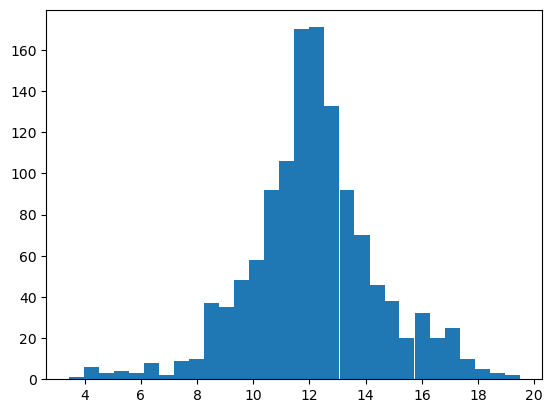

2

In [107]:
len(F.merge_coc_clusters(deepcopy([trained_sequences[0], trained_sequences[2]])))

### Figure finding

Starting with elec 1, loc: [59. 40.]

Finding coocurrences


  0%|          | 0/19333 [00:00<?, ?it/s]

100%|██████████| 19333/19333 [00:08<00:00, 2368.33it/s]


3884 cocs total

Unimodal amp/median with p-value: 0.000

Comparing to elec 3, loc: [43. 60.]
cluster 0, mean: 0.544, std: 0.942, #cocs: 1256
cluster 1, mean: 8.950, std: 1.231, #cocs: 1033


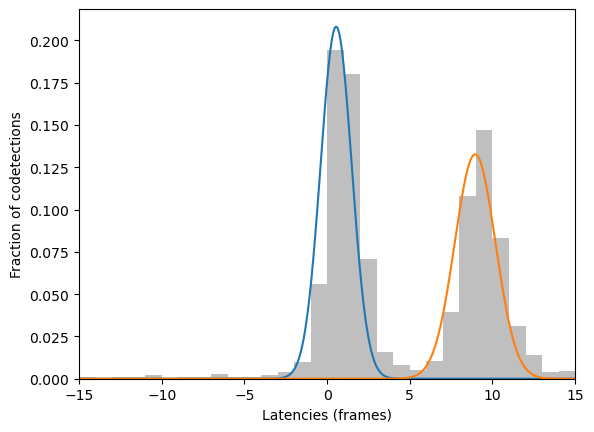

AssertionError: 

In [61]:
# Find good-example of mulitmodal latency distribution
# Need to uncomment code in branch_coc_clusters
clusters = F.form_coc_clusters(1, TRAINING_MS, verbose=True)

Starting with elec 1, loc: [59. 40.]

Finding coocurrences


  0%|          | 0/19333 [00:00<?, ?it/s]

100%|██████████| 19333/19333 [00:08<00:00, 2284.13it/s]


3884 cocs total

Unimodal amp/median with p-value: 0.000

Comparing to elec 3, loc: [43. 60.]
Found 2 clusters
2662 cocs remaining

Comparing to elec 2, loc: [27. 40.]
Found 1 clusters
2039 cocs remaining

Comparing to elec 5, loc: [59. 80.]
Found 2 clusters
1342 cocs remaining

Cluster 1: p-val=0.0432


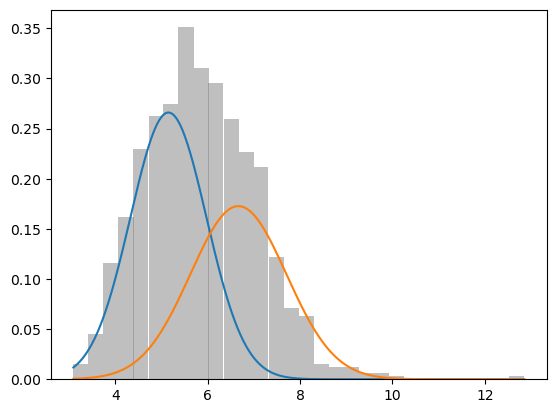

Split cluster 1 into 2 clusters

Total: 5 clusters


In [65]:
# Find good-example of mulitmodal amplitude distribution
clusters = F.form_coc_clusters(1, TRAINING_MS, verbose=True)

Starting with elec 17, loc: [ 59. 200.]

Finding coocurrences


  0%|          | 0/34922 [00:00<?, ?it/s]

100%|██████████| 34922/34922 [00:20<00:00, 1700.07it/s]


4693 cocs total

Unimodal amp/median with p-value: 0.220

Comparing to elec 19, loc: [ 43. 220.]
Found 5 clusters
4078 cocs remaining

Comparing to elec 15, loc: [ 43. 180.]
Found 4 clusters
3858 cocs remaining

Comparing to elec 18, loc: [ 27. 200.]
Found 2 clusters
3807 cocs remaining

Comparing to elec 21, loc: [ 59. 240.]
Found 1 clusters
3678 cocs remaining

Comparing to elec 13, loc: [ 59. 160.]
Found 2 clusters
1783 cocs remaining

Cluster 0: p-val=0.0018
cluster 0, mean: 6.668, std: 1.634
cluster 1, mean: 15.478, std: 3.789


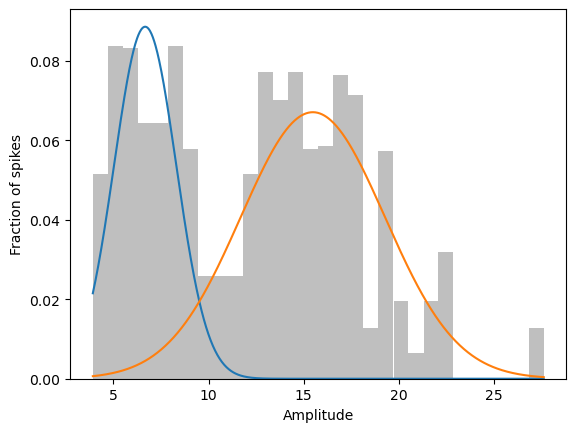

Split cluster 0 into 2 clusters

Cluster 12: p-val=0.0005
cluster 0, mean: 13.608, std: 3.563
cluster 1, mean: 5.310, std: 1.446


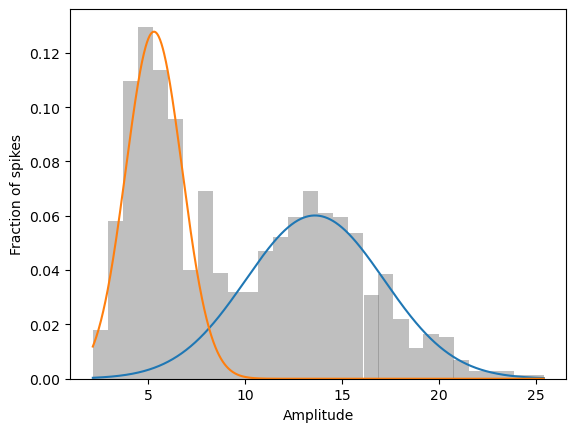

Split cluster 12 into 2 clusters

Total: 14 clusters


In [74]:
# Find good-example of mulitmodal amplitude distribution
clusters = F.form_coc_clusters(17, TRAINING_MS, verbose=True)

 33%|███▎      | 83/248 [01:56<03:08,  1.15s/it]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 52%|█████▏    | 128/248 [02:15<01:35,  1.25it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
100%|██████████| 248/248 [03:50<00:00,  1.08it/s]


1655 sequences before merging


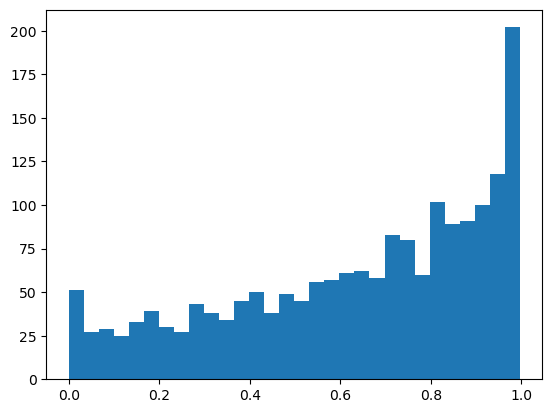

In [92]:
# Save all dip test p-values for splitting root amplitudes
# Need to uncomment 3 blocks of code near end of form_coc_clusters
P_INTER_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240319/all_amp_splitting_dip_p_values")  # Need to cache data 
##
P_INTER_PATH.mkdir(exist_ok=True, parents=True)
F.P_INTER_PATH = P_INTER_PATH
all_clusters = F.form_all_clusters(TRACES_TRAINING_MS)
all_p_values = []
for root_elec in range(NUM_ELECS):
    p_path = P_INTER_PATH / f"root_elec_{root_elec}.npy"
    if p_path.exists():
        all_p_values.extend(np.load(p_path))
plt.hist(all_p_values, bins=30)
np.save(P_INTER_PATH / "all_values.npy", all_p_values)

## Testing ground-truth

In [16]:
merged_sequences = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/230113/merged_sequences.pickle")
merged_sequences = sorted(merged_sequences, key=lambda seq: list(ELEC_LOCS[seq.root_elec]))
for idx, seq in enumerate(merged_sequences):
    seq.idx = idx

In [50]:
len([seq for seq in merged_sequences if len(seq.spike_train) > 15])

376

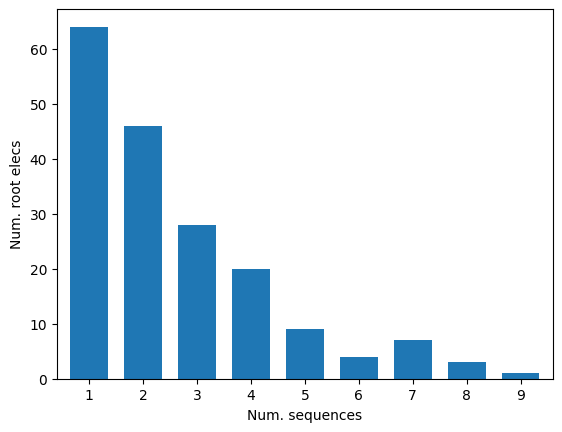

#elecs >= 4 seqs: 231


In [48]:
counts = {}
for seq in merged_sequences:
    if seq.root_elec not in counts:
        counts[seq.root_elec] = 1
    else:
        counts[seq.root_elec] += 1
        
from src import plot
counts_array = np.array(list(counts.values()))
plot.bar(counts_array)
plt.xlabel("Num. sequences")
plt.ylabel("Num. root elecs")
plt.show()
print("#elecs >= 4 seqs:", np.sum(counts_array[counts_array >= 4]))

In [ ]:
counts = {}
for seq in merged_sequences:
    if seq.root_elec not in counts:
        counts[seq.root_elec] = [seq]
    else:
        counts[seq.root_elec].append(seq)
for elec, seqs in counts.items():
    if len(seqs) >= 4:
        for seq in seqs:
            F.plot_elec_probs(seq, use_filt=False)
            plt.show()

In [161]:
## Examine merge scores of seq pair
cluster_i = trained_sequences[4]
cluster_j = trained_sequences[5]

print(f"Seqs {cluster_i.idx} and {cluster_j.idx}")

total_loose = len(set(cluster_i.loose_elecs).union(cluster_j.loose_elecs))
num_loose_overlaps = len(set(cluster_i.loose_elecs).intersection(cluster_j.loose_elecs))
print(f"Elec overlap: {num_loose_overlaps / total_loose:.2f}")

i_comp_elecs = cluster_i.comp_elecs
i_comp_elecs_set = set(i_comp_elecs)
j_comp_elecs = cluster_j.comp_elecs
comp_elecs = i_comp_elecs + [elec for elec in j_comp_elecs if elec not in i_comp_elecs_set]  # Prevents counting an elec more than once

# Get elec probs
i_elec_probs = cluster_i.all_elec_probs[comp_elecs]
j_elec_probs = cluster_j.all_elec_probs[comp_elecs]

# Compare latencies
i_latencies = cluster_i.all_latencies[comp_elecs][1:]
j_latencies = cluster_j.all_latencies[comp_elecs][1:] - cluster_i.all_latencies[comp_elecs[0]]
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=True)
latency_diff = np.abs(i_latencies - j_latencies)
latency_diff = np.clip(latency_diff, a_min=None, a_max=F.CLIP_LATENCY_DIFF)
latency_diff = np.sum(latency_diff * elec_weights)
print(f"Latency diff: {latency_diff:.2f}")

i_amp_medians = cluster_i.all_amp_medians[comp_elecs]
j_amp_medians = cluster_j.all_amp_medians[comp_elecs]                
elec_weights = F.get_elec_weights(i_elec_probs, j_elec_probs, for_latencies=False)
amp_median_div = (i_amp_medians + j_amp_medians) / 2
amp_median_diff = np.abs((i_amp_medians - j_amp_medians)) / amp_median_div
amp_median_diff = np.clip(amp_median_diff, a_min=None, a_max=F.CLIP_AMP_MEDIAN_DIFF)
amp_median_diff = np.sum(amp_median_diff * elec_weights)
print(f"Amp diff : {amp_median_diff:.2f}")

for root_elec in set(cluster_i.root_elecs + cluster_j.root_elecs):
    root_amps_i = cluster_i.every_amp_median[root_elec, :] # get_amp_medians(cluster_i, root_elec=root_elec)
    root_amps_j = cluster_j.every_amp_median[root_elec, :] # get_amp_medians(cluster_j, root_elec=root_elec)
    dip, pval = diptest(np.concatenate([root_amps_i, root_amps_j]))
    print(f"Elec {root_elec} p-val: {pval:.2f}")

Seqs 4 and 5
Elec overlap: 1.00
Latency diff: 0.78
Amp diff : 0.08
Elec 2 p-val: 0.00


In [133]:
F.calc_elec_dist(cluster_i.root_elec, cluster_j.root_elec)

101.27191120937731

### Ground truth

In [54]:
gt_sequences = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/ground_truth_sequences.pickle")
gt_sequences = sorted(gt_sequences, key=lambda seq: list(ELEC_LOCS[seq.root_elec]))
elec_to_gt_seq = {}
for idx, seq in enumerate(gt_sequences):
    seq.idx = idx
    if seq.root_elec not in elec_to_gt_seq:
        elec_to_gt_seq[seq.root_elec] = [seq]
    else:
        elec_to_gt_seq[seq.root_elec].append(seq)

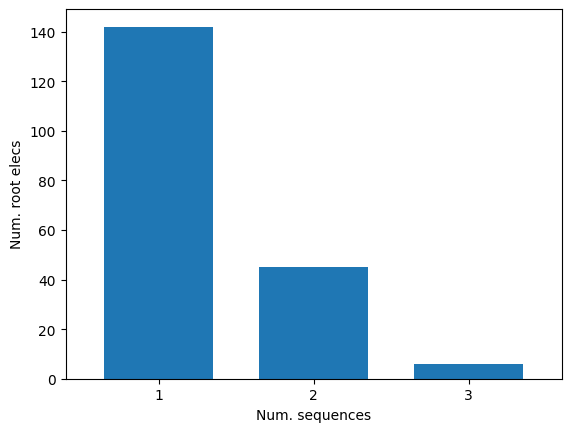

In [80]:
counts = {}
for seq in gt_sequences:
    if seq.root_elec not in counts:
        counts[seq.root_elec] = 1
    else:
        counts[seq.root_elec] += 1
        
from src import plot
plot.bar(list(counts.values()))
plt.xlabel("Num. sequences")
plt.ylabel("Num. root elecs")
plt.show()

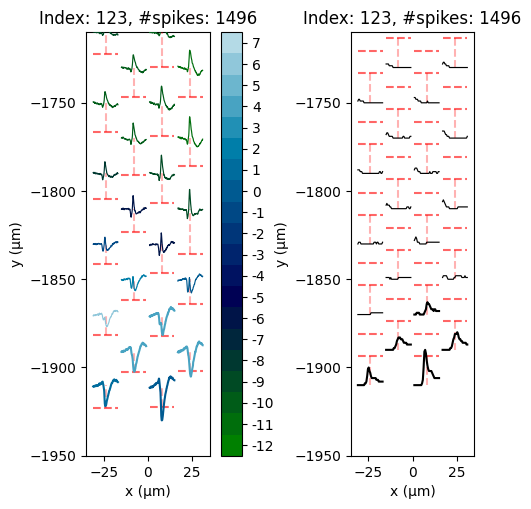

In [66]:
# for seq in gt_sequences[5:25]:    
root_elec = 0
for elec in [root_elec] + ALL_CLOSEST_ELECS[root_elec]:
    if F.calc_elec_dist(root_elec, elec) > F.INNER_RADIUS:
        break
    
    if elec in elec_to_gt_seq:
        for seq in elec_to_gt_seq[elec]:
            F.plot_elec_probs(seq, use_filt=False)
            plt.show()

In [65]:
# for seq in tqdm(gt_sequences):
#     F.plot_elec_probs(seq, use_filt=False)
#     plt.savefig(f"/data/MEAprojects/dandi/000034/sub-MEAREC-250neuron-Neuropixels/rt_sort/ground_truth_sequences/footprints/{seq.idx}.jpg", format="jpg")
#     plt.close()

100%|██████████| 250/250 [03:09<00:00,  1.32it/s]


## Full run - DL model

In [9]:
stopwatch.start()
F.save_traces_si(SCALED_TRACES_PATH, start_ms=TRAINING_MS[0], end_ms=TESTING_MS[1])
stopwatch.stop()

Alllocating memory for traces ...
Extracting traces ...


100%|██████████| 248/248 [00:28<00:00,  8.73it/s]


In [10]:
from src.run_alg.model import ModelSpikeSorter
stopwatch.start()
model = ModelSpikeSorter.load(MODEL_PATH)
model.compile(NUM_ELECS, MODEL_PATH)
stopwatch.stop()

In [11]:
stopwatch.start()
F.run_dl_model(MODEL_PATH, SCALED_TRACES_PATH, MODEL_TRACES_PATH, MODEL_OUTPUTS_PATH)
stopwatch.stop()

Loading DL model ...
Allocating memory to save model traces and outputs ...
Inference scaling: 1
Running model ...


100%|██████████| 99999/99999 [02:38<00:00, 629.17it/s]


In [12]:
stopwatch.start()
F.NUM_ELECS = NUM_ELECS
F.SAMP_FREQ = SAMP_FREQ
F.FRONT_BUFFER = FRONT_BUFFER
F.STRINGENT_THRESH = STRINGENT_THRESH
F.STRINGENT_THRESH_LOGIT = STRINGENT_THRESH_LOGIT
F.extract_crossings(MODEL_OUTPUTS_PATH, ALL_CROSSINGS_PATH, ELEC_CROSSINGS_IND_PATH)
stopwatch.stop()
print(f"Time to run DL model: {stopwatch.duration} seconds")

  0%|          | 0/17999 [00:00<?, ?it/s]

100%|██████████| 17999/17999 [01:17<00:00, 232.61it/s]


Time to run DL model: 299.5621783733368 seconds


## Full run - sequences

In [12]:
ROOT_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240319")

In [15]:
# stopwatch.start()
# assert False, "make sure ROOT_PATH is correct"
# ROOT_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240319_speed_test_240327")
# ROOT_PATH.mkdir(exist_ok=True, parents=True)
# MIN_SPIKES = max(10, 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000)

# all_clusters = F.form_all_clusters(TRACES_TRAINING_MS)
# all_clusters_reassigned = F.reassign_spikes(all_clusters, TRACES_TRAINING_MS, MIN_SPIKES)
# intra_merged_clusters = F.intra_merge(all_clusters_reassigned) 
# trained_sequences = F.inter_merge(intra_merged_clusters, MIN_SPIKES)

# stopwatch.stop()
# print(f"Time to detect sequences: {stopwatch.duration} seconds")

# # Save data
# utils.pickle_dump(all_clusters, ROOT_PATH / "all_clusters.pickle")
# utils.pickle_dump(all_clusters_reassigned, ROOT_PATH / "all_clusters_reassigned.pickle")
# utils.pickle_dump(trained_sequences, ROOT_PATH / "trained_sequences.pickle")

 32%|███▏      | 80/248 [01:48<02:16,  1.23it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 53%|█████▎    | 131/248 [02:15<01:59,  1.02s/it]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
100%|██████████| 248/248 [03:44<00:00,  1.10it/s]


1655 sequences before merging


  8%|▊         | 16/204 [00:01<00:23,  7.94it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 22%|██▏       | 44/204 [00:03<00:06, 23.26it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 41%|████      | 83/204 [00:04<00:02, 49.46it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 55%|█████▍    | 112/204 [00:04<00:

356 sequences after first merging


/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)



Merged 288 with 276
Latency diff: 0.13. Amp median diff: 0.06
Amp dist p-value 0.3682
#spikes:
Merge base: 1812, Add: 1933, Overlaps: 2
After merging: 3666

Merged 6 with 1
Latency diff: 0.14. Amp median diff: 0.09
Amp dist p-value 0.4978
#spikes:
Merge base: 3266, Add: 2451, Overlaps: 9
After merging: 5708

Merged 136 with 128
Latency diff: 0.23. Amp median diff: 0.07
Amp dist p-value 0.3049
#spikes:
Merge base: 360, Add: 953, Overlaps: 1
After merging: 1309

Merged 84 with 46
Latency diff: 0.24. Amp median diff: 0.07
Amp dist p-value 0.3518
#spikes:
Merge base: 3177, Add: 5340, Overlaps: 17
After merging: 8484

Merged 95 with 68
Latency diff: 0.17. Amp median diff: 0.09
Amp dist p-value 0.4136
#spikes:
Merge base: 3509, Add: 1520, Overlaps: 7
After merging: 5022

Merged 319 with 307
Latency diff: 0.30. Amp median diff: 0.08
Amp dist p-value 0.6226
#spikes:
Merge base: 1791, Add: 1020, Overlaps: 3
After merging: 2771

Merged 11 with 0
Latency diff: 0.15. Amp median diff: 0.11
Amp dis

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


After merging: 20540

Merged 108 with 119
Latency diff: 0.29. Amp median diff: 0.15
Amp dist p-value 0.3584
#spikes:
Merge base: 2690, Add: 3639, Overlaps: 7
After merging: 6322

Merged 234 with 238
Latency diff: 0.17. Amp median diff: 0.18
Amp dist p-value 0.8091
#spikes:
Merge base: 244, Add: 80, Overlaps: 0
After merging: 324

Merged 295 with 305
Latency diff: 0.28. Amp median diff: 0.16
Amp dist p-value 0.4985
#spikes:
Merge base: 2419, Add: 2095, Overlaps: 6
After merging: 4506

Merged [221, 253] with 212
Latency diff: 0.29. Amp median diff: 0.16
Amp dist p-value 0.2291
#spikes:
Merge base: 9424, Add: 5252, Overlaps: 22
After merging: 14653

Merged 22 with 16
Latency diff: 0.18. Amp median diff: 0.18
Amp dist p-value 0.3999
#spikes:
Merge base: 6214, Add: 4606, Overlaps: 6
After merging: 10811

Merged 209 with 258
Latency diff: 0.21. Amp median diff: 0.18
Amp dist p-value 1.0391
#spikes:
Merge base: 2818, Add: 2533, Overlaps: 4
After merging: 5339

Merged 213 with 241
Latency diff

### Run each part separately

In [10]:
ROOT_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240319")
ROOT_PATH.mkdir(exist_ok=True, parents=True)

MIN_SPIKES = max(10, 0.05 * (TRAINING_MS[1] - TRAINING_MS[0]) / 1000)

In [ ]:
all_clusters = F.form_all_clusters(TRACES_TRAINING_MS)

 34%|███▍      | 84/248 [01:56<02:42,  1.01it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 50%|█████     | 124/248 [02:10<01:15,  1.64it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
100%|██████████| 248/248 [03:50<00:00,  1.08it/s]


1655 sequences before merging


In [ ]:
utils.pickle_dump(all_clusters, ROOT_PATH / "all_clusters.pickle")

In [ ]:
all_clusters = utils.pickle_load(ROOT_PATH / "all_clusters.pickle")

In [ ]:
all_clusters_reassigned = F.reassign_spikes(all_clusters, TRACES_TRAINING_MS, MIN_SPIKES)

100%|██████████| 1613/1613 [04:05<00:00,  6.58it/s]


In [ ]:
utils.pickle_dump(all_clusters_reassigned, ROOT_PATH / "all_clusters_reassigned.pickle")

In [ ]:
all_clusters_reassigned = utils.pickle_load(ROOT_PATH / "all_clusters_reassigned.pickle")

In [ ]:
# # Test merging
# root_elec_to_clusters = {}
# for cluster in utils.pickle_load(ROOT_PATH / "all_clusters_reassigned.pickle"):
#     if cluster.root_elec not in root_elec_to_clusters:
#         root_elec_to_clusters[cluster.root_elec] = [cluster]
#     else:
#         root_elec_to_clusters[cluster.root_elec].append(cluster)
# tasks = list(root_elec_to_clusters.values())

# F.merge_coc_clusters(root_elec_to_clusters[1], verbose=True)

# for clust in root_elec_to_clusters[1]:
#     F.plot_elec_probs(clust)
#     plt.show()

In [ ]:
# Merge clusters with the same root electrode
intra_merged_clusters = F.intra_merge(all_clusters_reassigned) 

  7%|▋         | 15/204 [00:01<00:18,  9.99it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 24%|██▎       | 48/204 [00:02<00:05, 29.13it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
 43%|████▎     | 88/204 [00:03<00:01, 63.93it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
 52%|█████▏    | 107/204 [00:04<00:02, 47.59it/s]/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims,

356 sequences after first merging


In [ ]:
trained_sequences = F.inter_merge(intra_merged_clusters, MIN_SPIKES)

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:244: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)



Merged 282 with 273
Latency diff: 0.13. Amp median diff: 0.06
Amp dist p-value 0.3682
#spikes:
Merge base: 1812, Add: 1933, Overlaps: 2
After merging: 3666

Merged 185 with 190
Latency diff: 0.16. Amp median diff: 0.07
Amp dist p-value 0.5625
#spikes:
Merge base: 1182, Add: 1904, Overlaps: 7
After merging: 3079

Merged 126 with 136
Latency diff: 0.19. Amp median diff: 0.07
Amp dist p-value 0.3049
#spikes:
Merge base: 360, Add: 953, Overlaps: 1
After merging: 1309

Merged 6 with 4
Latency diff: 0.14. Amp median diff: 0.09
Amp dist p-value 0.4978
#spikes:
Merge base: 3266, Add: 2451, Overlaps: 9
After merging: 5708

Merged 69 with 30
Latency diff: 0.24. Amp median diff: 0.07
Amp dist p-value 0.3518
#spikes:
Merge base: 3177, Add: 5341, Overlaps: 17
After merging: 8485

Merged 101 with 64
Latency diff: 0.17. Amp median diff: 0.09
Amp dist p-value 0.4136
#spikes:
Merge base: 3509, Add: 1520, Overlaps: 7
After merging: 5022

Merged 309 with 289
Latency diff: 0.30. Amp median diff: 0.08
Amp

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


After merging: 20540

Merged 103 with 110
Latency diff: 0.29. Amp median diff: 0.15
Amp dist p-value 0.3586
#spikes:
Merge base: 2691, Add: 3639, Overlaps: 7
After merging: 6323

Merged 224 with 232
Latency diff: 0.17. Amp median diff: 0.18
Amp dist p-value 0.8091
#spikes:
Merge base: 244, Add: 80, Overlaps: 0
After merging: 324

Merged 285 with 307
Latency diff: 0.28. Amp median diff: 0.16
Amp dist p-value 0.4985
#spikes:
Merge base: 2420, Add: 2095, Overlaps: 6
After merging: 4507

Merged [239, 253] with 234
Latency diff: 0.29. Amp median diff: 0.16
Amp dist p-value 0.2291
#spikes:
Merge base: 9425, Add: 5252, Overlaps: 22
After merging: 14654

Merged 26 with 20
Latency diff: 0.18. Amp median diff: 0.18
Amp dist p-value 0.3999
#spikes:
Merge base: 6214, Add: 4606, Overlaps: 6
After merging: 10811

Merged 235 with 262
Latency diff: 0.21. Amp median diff: 0.18
Amp dist p-value 1.0391
#spikes:
Merge base: 2818, Add: 2533, Overlaps: 4
After merging: 5339

Merged 211 with 245
Latency diff

In [ ]:
utils.pickle_dump(trained_sequences, ROOT_PATH / "trained_sequences.pickle")

In [12]:
trained_sequences = utils.pickle_load(ROOT_PATH / "trained_sequences.pickle")

### Assign spikes in testing region

In [16]:
F.assign_spikes_torch(trained_sequences, TESTING_MS) 
torch.cuda.empty_cache()

100%|██████████| 59990/59990 [02:15<00:00, 442.44it/s]


In [17]:
utils.pickle_dump(trained_sequences, ROOT_PATH / "tested_sequences.pickle")

In [13]:
tested_sequences = utils.pickle_load(ROOT_PATH / "tested_sequences.pickle")

100%|██████████| 59990/59990 [02:57<00:00, 337.87it/s]


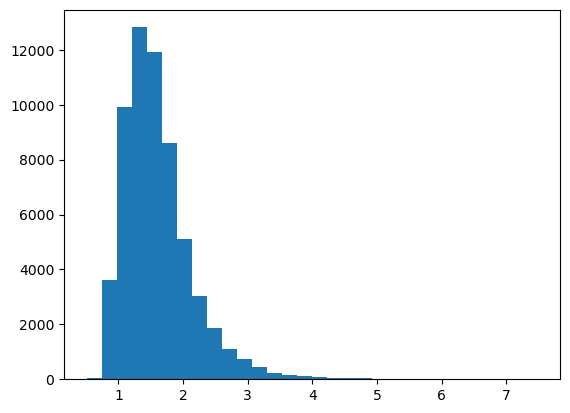

1.6002948815596854


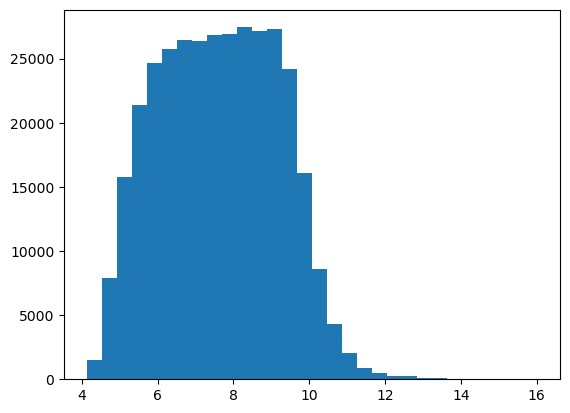

7.61924083549413


In [19]:
# Measure computation times (need to go in code and uncommment where there are break points in assign_spikes_torch)
F.MODEL_PATH = MODEL_PATH
F.SCALED_TRACES_PATH = SCALED_TRACES_PATH
sorting_computation_times, sorting_delays = F.measure_speed_assign_spikes_torch(trained_sequences, TESTING_MS) 
torch.cuda.empty_cache()
plt.hist(sorting_computation_times, bins=30) 
plt.show()
print(np.mean(sorting_computation_times))

plt.hist(sorting_delays, bins=30) 
plt.show()
print(np.mean(sorting_delays))

In [20]:
np.save(ROOT_PATH / "sorting_computation_times.npy", sorting_computation_times)
np.save(ROOT_PATH / "sorting_delays.npy", sorting_delays)

### Manual analysis

In [ ]:
# Plot sequences
use_formation_spike_train = False
use_filt = False  # If True, amp in footprint may not match histogram (histogram does not use filtered traces)

for seq in trained_sequences[10:20]:
    F.plot_elec_probs(seq, idx=seq.idx, use_formation_spike_train=use_formation_spike_train, use_filt=use_filt)
    plt.show()
            
    # amp_medians = seq.every_amp_median[seq.root_elec, :]
    amp_medians = F.get_amp_medians(seq).flatten()
    plt.hist(amp_medians, bins=30)
    plt.show()
    print(np.mean(amp_medians))
    
    print(f"dip p-val: {diptest(amp_medians)[1]:.3f}")

In [ ]:
# Split amp dist
SPLIT_AMP = 7
    
spikes1 = []
spikes2 = []
for time, amp in zip(seq.spike_train, F.get_amp_medians(seq)):
    if amp < SPLIT_AMP:
        spikes1.append(time)
    else:
        spikes2.append(time)
F.plot_spikes(spikes1, seq.root_elec)
plt.show()
F.plot_spikes(spikes2, seq.root_elec)
plt.show()

In [16]:
tested_sequences = [seq for seq in tested_sequences if len(seq.spike_train) > 0]
F.save_sequences_plots(tested_sequences, ROOT_PATH / "footprints")

100%|██████████| 475/475 [02:30<00:00,  3.15it/s]


In [ ]:
F.plot_elec_probs(tested_sequences[])

In [ ]:
prop_signal = F.clusters_to_sorter(tested_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, ROOT_PATH / "prop_signal.pickle")

### Save good-looking sequences for RT-Sort manuscript
Good looking = large footprint with clear propagation

In [13]:
trained_sequences = utils.pickle_load(ROOT_PATH / "trained_sequences.pickle")
tested_sequences = utils.pickle_load(ROOT_PATH / "tested_sequences.pickle")

In [15]:
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240319/example_seqs/above_5snr")
# SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240319/example_seqs/below_5snr")

FORMAT = "svg"
##
SAVE_ROOT.mkdir(parents=True, exist_ok=True)

In [39]:
# SEQ_IND = [0, 3, 15, 75, 149, 119, 122, 103]   # Good-looking examples
SEQ_IND = [9, 72, 137, 15]  # Good-looking examples that are also below 5SNR

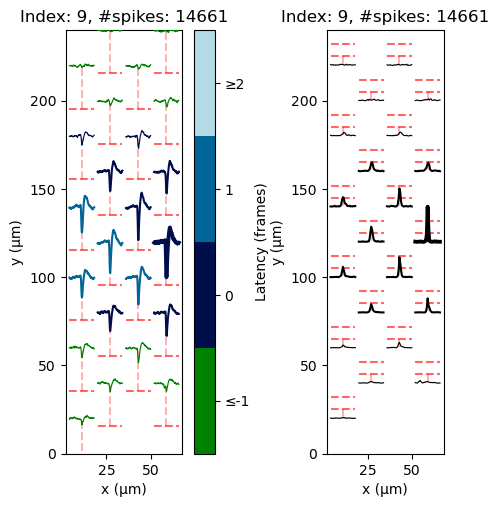

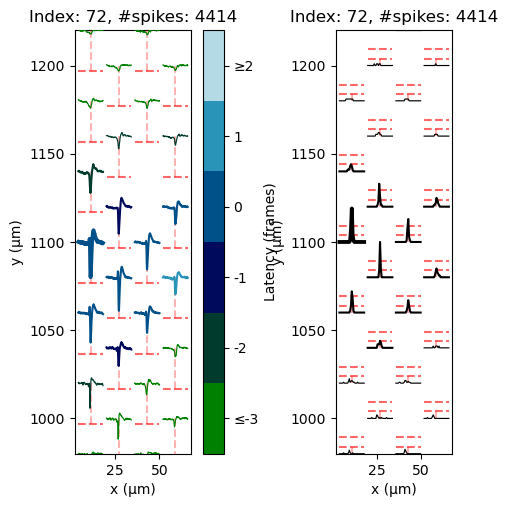

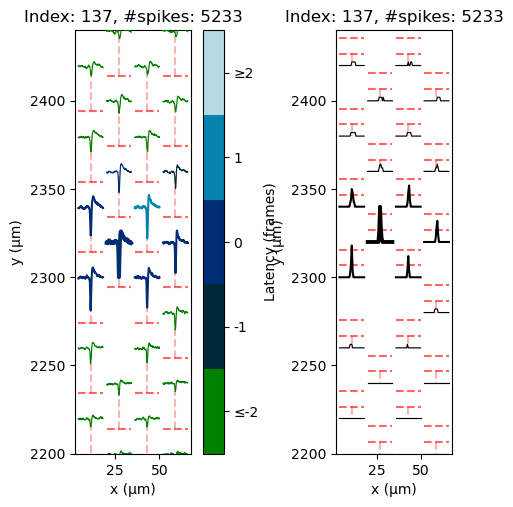

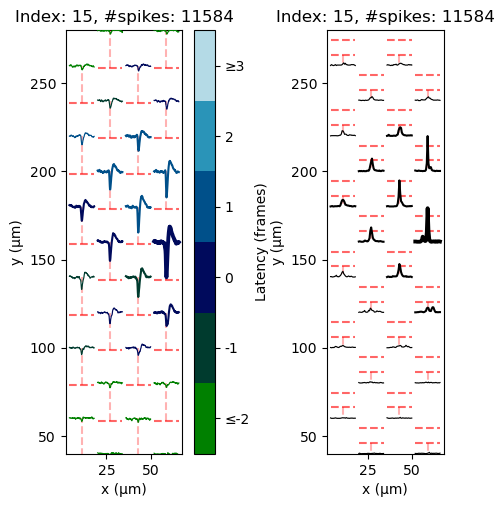

In [41]:
# Find some good-looking sequences
# np.random.seed(4)
# for seq in np.random.choice(trained_sequences, 10):
#     F.plot_elec_probs(seq)
#     plt.show()

for idx in SEQ_IND:
    F.plot_elec_probs(trained_sequences[idx])
    plt.show()

In [42]:
for idx in SEQ_IND:
    print(f"\nStarting on sequence {idx} ...")
    seq_save_root = SAVE_ROOT / str(idx)
    seq_save_root.mkdir(exist_ok=True, parents=True)

    seq = trained_sequences[idx]
    amp_kwargs, prob_kwargs = F.plot_elec_probs(seq, debug=False)
    plt.savefig(seq_save_root / f"first_5_min_footprint.{FORMAT}", format=FORMAT)
    plt.close()
    # plt.show()
    
    spikes_save_root = seq_save_root / "5_10_min_spikes"
    spikes_save_root.mkdir(exist_ok=True, parents=True)
    spike_train = tested_sequences[idx].spike_train
    np.random.seed(231)
    for s in tqdm(np.random.choice(len(spike_train), 15, replace=False)):
        F.plot_spikes([spike_train[s]], seq.root_elec, debug=False, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
        plt.savefig(spikes_save_root / f"{s}.{FORMAT}", format=FORMAT)
        plt.close()
        # plt.show()
        # break 


Starting on sequence 0 ...


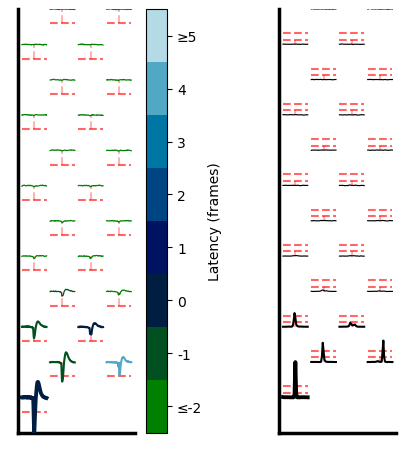

In [17]:
# Find good overlapping spike example
SEQ_IDX = 0
##  Get amp and prob kwargs
seq = trained_sequences[SEQ_IDX]
amp_kwargs, prob_kwargs = F.plot_elec_probs(seq, debug=False)
plt.show()

In [ ]:
# Actually search spikes now
seq = tested_sequences[SEQ_IDX]  # 1073, 121
spike_train = seq.spike_train
np.random.seed(3)
for s in np.random.choice(len(spike_train), 10, replace=False):
    print(s)
    F.plot_spikes([spike_train[s]], seq.root_elec, debug=False, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()

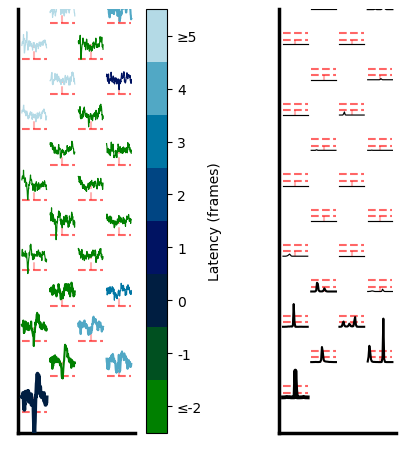

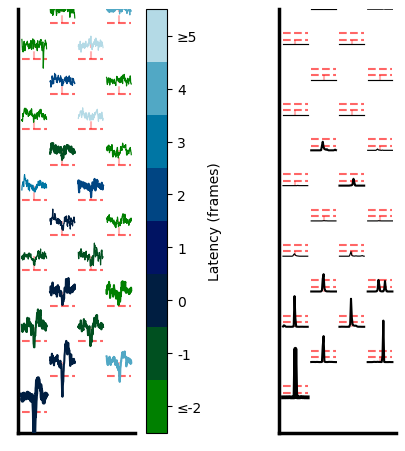

In [23]:
SPIKE_IND = [1073, 121]
##
for s in SPIKE_IND:
    seq_save_root = SAVE_ROOT / str(SEQ_IDX)
    spikes_save_root = seq_save_root / "5_10_min_spikes"
    F.plot_spikes([spike_train[s]], seq.root_elec, debug=False, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.savefig(spikes_save_root / f"{s}.{FORMAT}", format=FORMAT)
    plt.show()

## Compare to kilosort
For development and testing

### Setup

In [15]:
%autoreload 2
from src.comparison import Comparison
from src.sorters.base import SpikeSorter
from src.sorters.kilosort import get_experts_kilosort

In [11]:
# prop_signal = F.clusters_to_sorter(tested_sequences)
prop_signal = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240319/prop_signal.pickle")

# kilosort = get_experts_kilosort(testing_ms=TESTING_MS)

In [27]:
# # For deeper kilosort analysis, such as plotting individual kilosort units 
# kilosort = get_experts_kilosort(testing_ms=TESTING_MS)
# # kilosort = get_experts_kilosort(testing_ms=TRAINING_MS)

# # Create all_ks_units with self.templates and self.chan set --> Don't run this if already ran before
# all_ks_units = []

# def job(idx):
#     unit = Unit(idx, all_ks_spike_times[idx], -1, RECORDING)
#     templates = unit.get_templates()
#     unit.templates = templates
#     unit.recording = None
#     unit.chan = np.argmin(np.min(templates, axis=1))
#     unit.root_elecs = [unit.chan]
#     return unit

# all_ks_spike_times = kilosort.get_spike_times()
# with Pool(processes=20) as pool:
#     tasks = range(len(all_ks_spike_times))
#     for unit in tqdm(pool.imap(job, tasks), total=len(tasks)):
#         unit.recording = RECORDING
#         all_ks_units.append(unit)
        
# chan_to_ks_units = {}
# for unit in all_ks_units:
#     if unit.chan not in chan_to_ks_units:
#         chan_to_ks_units[unit.chan] = [unit]
#     else:
#         chan_to_ks_units[unit.chan].append(unit)

# chan_to_prop_units = {}
# for unit in final_sequences:
#     for chan in unit.root_elecs:
#         if chan not in chan_to_prop_units:
#             chan_to_prop_units[chan] = [unit]
#         else:
#             chan_to_prop_units[chan].append(unit)

Recording does not have scaled traces. Setting gain to 0.195


100%|██████████| 226/226 [05:22<00:00,  1.43s/it]


In [95]:
# Compare RT-Sort to different sorters
# The variable must be called "kilosort" but can represent another sorter
SORTERS_ROOT = Path("/data/MEAprojects/spikeinterface/spiketrains/mouse412804_probeC")
MAX_FR = 1000 
##
from spikeinterface.extractors import NpzSortingExtractor

class Sorter:
    # Wrapper of NpzSortingExtractor for Comparison
    def __init__(self, full_name, name):
        self.npz = NpzSortingExtractor(SORTERS_ROOT / full_name / "sorting_cached.npz")
        self.name = name
        
    def __len__(self):
        return len(self.get_spike_times()) 
    
    def get_spike_times(self, verbose=False):
        start_ms, end_ms = TESTING_MS
        
        # Number of units that...
        num_too_high_fr = 0
        num_zero_spikes = 0
        
        spike_times = []
        for uid in self.npz.get_unit_ids():
            times = self.npz.get_unit_spike_train(uid) / SAMP_FREQ
            times_ind = start_ms <= times
            times_ind *= times <= end_ms            
            
            if sum(times_ind) == 0:
                num_zero_spikes += 1
                continue
            
            if sum(times_ind) > MAX_FR * (end_ms - start_ms)/1000:
                num_too_high_fr += 1
                continue
            
            spike_times.append(times[times_ind])
            
        if verbose:
            print(f"{self.name} has {num_zero_spikes} units with no spikes in TESTING_MS and {num_too_high_fr} units with more than {MAX_FR}Hz")
        return spike_times
    
# kilosort = Sorter("herdingspikes", "herdingspikes")
# kilosort = Sorter("kilosort2", "kilosort2")
# kilosort = Sorter("ironclust", "ironclust")
# kilosort = Sorter("tridesclous", "tridesclous")
# kilosort = Sorter("spykingcircus", "spykingcircus")
# kilosort = Sorter("hdsort", "hdsort")

# Find which units have firing rate of 0 or more than MAX_FR
kilosort = Sorter("herdingspikes", "herdingspikes")
kilosort.get_spike_times(verbose=True)

kilosort = Sorter("kilosort2", "kilosort2")
kilosort.get_spike_times(verbose=True)

kilosort = Sorter("ironclust", "ironclust")
kilosort.get_spike_times(verbose=True)

kilosort = Sorter("tridesclous", "tridesclous")
kilosort.get_spike_times(verbose=True)

kilosort = Sorter("spykingcircus", "spykingcircus")
kilosort.get_spike_times(verbose=True)

kilosort = Sorter("hdsort", "hdsort")
_ = kilosort.get_spike_times(verbose=True)  # _ = to Prevent jupyter notebook from printing these spike times

herdingspikes has 1 units with no spikes in TESTING_MS and 0 units with more than 1000Hz
kilosort2 has 0 units with no spikes in TESTING_MS and 0 units with more than 1000Hz
ironclust has 13 units with no spikes in TESTING_MS and 1 units with more than 1000Hz
tridesclous has 0 units with no spikes in TESTING_MS and 0 units with more than 1000Hz
spykingcircus has 12 units with no spikes in TESTING_MS and 0 units with more than 1000Hz
hdsort has 4 units with no spikes in TESTING_MS and 0 units with more than 1000Hz


### Start comparing

In [ ]:
# Comparison.count_all_overlaps(prop_signal.get_spike_times(), kilosort.get_spike_times())

In [ ]:
comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5, delta_time=0.4)
comp_1_5.summary()
# comp_1_5.plot_line_comps()

comp_1 = Comparison(prop_signal, kilosort, score_formula=1, delta_time=0.4)
comp_1.summary()
# # comp_1.plot_line_comps()

comp_2 = Comparison(prop_signal, kilosort, score_formula=2, delta_time=0.4)
comp_2.summary()
# # comp_2.plot_line_comps()

# Comparison.plot_comp_1_2_scatter(comp_1, comp_2)

#### Save histograms for RT-Sort manuscript

In [88]:
# kilosort = Sorter("herdingspikes", "herdingspikes")
# kilosort = Sorter("kilosort2", "kilosort2")
# kilosort = Sorter("ironclust", "ironclust")
# kilosort = Sorter("tridesclous", "tridesclous")
# kilosort = Sorter("spykingcircus", "spykingcircus")
# kilosort = Sorter("hdsort", "hdsort")
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240319/overlap_score_histograms/240325")
for kilosort in (
    Sorter("herdingspikes", "herdingspikes"),
    Sorter("kilosort2", "kilosort2"),
    Sorter("ironclust", "ironclust"),
    Sorter("tridesclous", "tridesclous"),
    Sorter("spykingcircus", "spykingcircus"),
    Sorter("hdsort", "hdsort"),
):
    comp_1_5 = Comparison(prop_signal, kilosort, score_formula=1.5, delta_time=0.4)
    comp_1_5.summary(SAVE_ROOT / kilosort.name / "spikeinterface_formula.svg")
    
    # comp_1 = Comparison(prop_signal, kilosort, score_formula=1, delta_time=0.4)
    # comp_1.summary(SAVE_ROOT / kilosort.name / "num_matches_over_num_rt_sort.svg")
    
    # comp_2 = Comparison(prop_signal, kilosort, score_formula=2, delta_time=0.4)
    # comp_2.summary(SAVE_ROOT / kilosort.name / "num_matches_over_num_other_sorter.svg")
    
    # Comparison.plot_comp_1_2_scatter(comp_1, comp_2, SAVE_ROOT / kilosort.name / "scatter.svg")

Num RT-Sort: 168
Num herdingspikes: 209

Spikeinterface formula
17/168 matches
18/168 max matches
Num RT-Sort: 168
Num kilosort2: 448

Spikeinterface formula
22/168 matches
23/168 max matches
Num RT-Sort: 168
Num ironclust: 220

Spikeinterface formula
21/168 matches
22/168 max matches
Num RT-Sort: 168
Num tridesclous: 187

Spikeinterface formula
21/168 matches
22/168 max matches
Num RT-Sort: 168
Num spykingcircus: 616

Spikeinterface formula
18/168 matches
19/168 max matches
Num RT-Sort: 168
Num hdsort: 313

Spikeinterface formula
17/168 matches
18/168 max matches


## Kilosort units as sequences
Test assigning spikes by treating kilosort units as sequences

In [9]:
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230")

In [10]:
%autoreload 2
from src.comparison import Comparison
from src import plot
from src.sorters.base import Unit
from src.sorters.kilosort import get_experts_kilosort

In [12]:
kilosort = get_experts_kilosort(testing_ms=TRAINING_MS, overlap_time=0.1)

/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.2.0 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.6.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/si_dl_ss/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match

Recording does not have scaled traces. Setting gain to 0.195


In [13]:
# Setup kilosort units as sequences --> need to find root elec (max-amp elec)

original_ks_sequences = []
original_ks_spike_times = kilosort.get_spike_times()
chan_to_ks_seqs = {}

def job(idx):    
    cluster = F.CocCluster(-1, -1, original_ks_spike_times[idx])
    
    all_waveforms = F.extract_waveforms(cluster)   
    templates = np.mean(all_waveforms, axis=0)
    root_elec = np.argmin(np.min(templates, axis=1))
    
    cluster.root_elec = root_elec
    cluster.root_elecs = [root_elec]
    # F.setup_cluster(cluster)
    
    return cluster

# with Pool(processes=20) as pool:
#     tasks = range(len(original_ks_spike_times))
#     for idx, cluster in tqdm(enumerate(pool.imap(job, tasks)), total=len(tasks)):
#         cluster.idx = idx
#         original_ks_sequences.append(cluster)
        
# for seq in chan_to_ks_seqs:
#     if seq.root_elec not in chan_to_ks_seqs:
#         chan_to_ks_seqs[seq.root_elec] = [seq]
#     else:
#         chan_to_ks_seqs[seq.root_elec].append(seq)

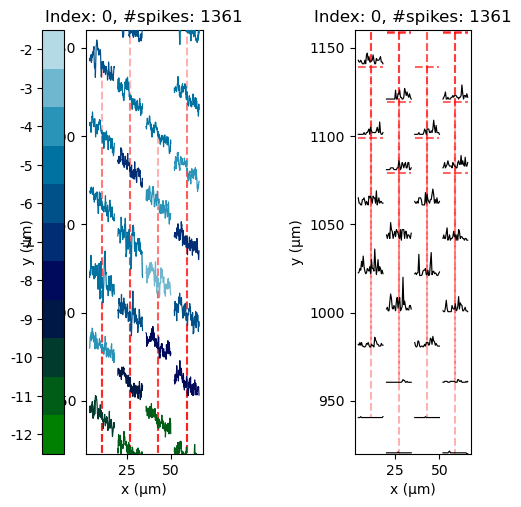

In [ ]:
unit = job(0)
F.plot_elec_probs(unit)
plt.show()

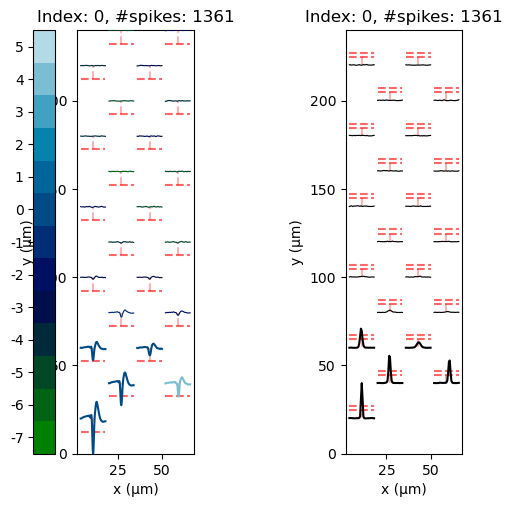

In [24]:
unit = job(0)
F.plot_elec_probs(unit)
plt.show()

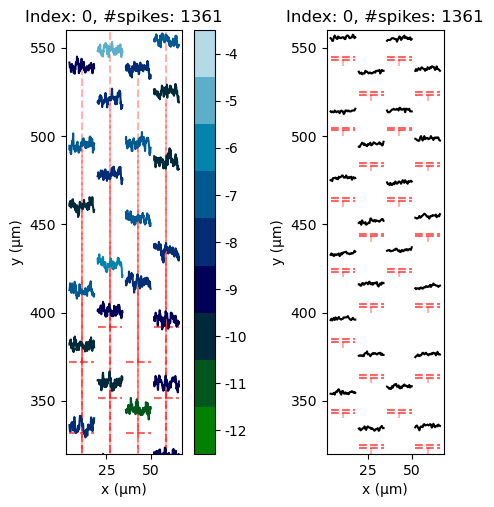

In [18]:
F.TRACES = np.load(SCALED_TRACES_PATH, mmap_mode="r")
F.OUTPUTS = F.TRACES
unit = job(0)
F.plot_elec_probs(unit)
plt.show()

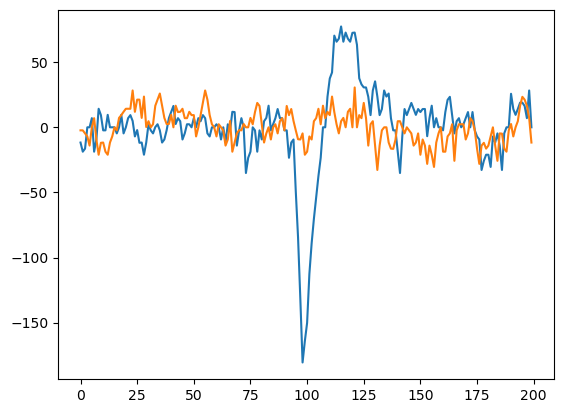

In [24]:
spike = unit.spike_train[2]
frame = round(spike * SAMP_FREQ)
trace = RECORDING.get_traces(start_frame=frame-100, end_frame=frame+100, 
                             channel_ids=[RECORDING.get_channel_ids()[0]], return_scaled=True).flatten().astype('float32')
plt.plot(trace)
plt.plot(F.TRACES[0, frame-100:frame+100])
plt.show()

In [ ]:
# viol_p = []
# for seq in original_ks_sequences:
#     spike_train = seq.spike_train
#     isis = np.diff(spike_train)
#     num_viols = np.sum(isis <= 1.5)
#     viol_p.append(num_viols / len(spike_train) * 100)
# plt.hist(viol_p, bins=60)
# plt.show()

In [13]:
# Called "all" but these are the sequences that can be detected by RT-Sort (at least 2 loose elecs)
all_ks_sequences = []
all_ks_spike_times = []

un_ks_sequences = []  # Sequences that cannot be detected by RT-Sort
for seq, times in zip(original_ks_sequences, original_ks_spike_times):
    if len(seq.loose_elecs) >= 2:
        all_ks_sequences.append(seq)
        all_ks_spike_times.append(times)
    else:
        un_ks_sequences.append(seq)
        
print(f"{len(original_ks_sequences)} kilosort units")
print(f"{len(all_ks_sequences)} detectable kilosort units (at least 2 loose elecs)")

226 kilosort units
211 detectable kilosort units (at least 2 loose elecs)


In [130]:
for seq in un_ks_sequences:
    F.plot_elec_probs(seq)
    # plt.savefig(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints_undetectable/{seq.idx}.jpg", format="jpg")
    # plt.close()

In [15]:
F.assign_spikes(all_ks_sequences, TRAINING_MS,
                interelec=True, only_max_amps=False,
                verbose=True)

100%|██████████| 3909373/3909373 [24:15<00:00, 2685.31it/s]


In [132]:
for seq in all_ks_sequences:
    if len(seq.spike_train) == 0:
        seq._spike_train = seq.formation_spike_train
        F.plot_elec_probs(seq)
        seq._spike_train = []
        plt.savefig(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints/no_spikes/{seq.idx}.jpg", format="jpg")
        plt.close()

In [16]:
utils.pickle_dump(all_ks_sequences, SAVE_ROOT / "all_ks_sequences.pickle")
prop_signal = F.clusters_to_sorter(all_ks_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, SAVE_ROOT / "ks_as_prop_signal.pickle")

In [21]:
# ks_as_prop_signal = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231219/ks_as_prop_signal.pickle")
# all_ks_sequences = []
# for unit in ks_as_prop_signal:
#     unit.root_elec = unit.chan
#     all_ks_sequences.append(unit)

In [111]:
# Naive way to check precision and recall (does not account for location of units when finding spike match)
all_prop_spikes = []
for seq in all_ks_sequences:
    all_prop_spikes.extend(seq.spike_train)
all_prop_spikes = np.sort(all_prop_spikes)

all_ks_spikes = []
for spike_train in all_ks_spike_times:
    all_ks_spikes.extend(spike_train)
all_ks_spikes = np.sort(all_ks_spikes)

matching_prop_times, unmatched_prop_times, unmatched_ks_times = Comparison.get_matching_events(all_prop_spikes, all_ks_spikes)

# num_matches = len(matching_prop_times)
# print(f"#matches: {num_matches}")
# print(f"#matches/#rt_sort: {num_matches/(len(unmatched_prop_times) + num_matches)*100:.1f}%")
# print(f"#matches/#kilosort: {num_matches/(len(unmatched_ks_times) + num_matches)*100:.1f}%")

tp = len(matching_prop_times)
fp = len(unmatched_prop_times)
fn = len(unmatched_ks_times)
print(f"For RT-Sort, relative to kilosort")
print(f"Precision: {tp / (tp+fp) *100:.1f}%")
print(f"Recall: {tp / (tp + fn) *100:.1f}%")

For RT-Sort, relative to kilosort
Precision: 83.9%
Recall: 49.5%


In [110]:
# Correct way to check precision and recall

# Need to format as Unit objects for F.select_prop_spikes_within_kilosort_spikes
all_ks_units = []  # Contains spikes detected by kilosort
all_prop_units = []  # Contains spikes detected with rt_sort method
for idx, (ks_spike_times, ks_sequence) in enumerate(zip(all_ks_spike_times, all_ks_sequences)):
    all_ks_units.append(Unit(idx, ks_spike_times, ks_sequence.root_elec, None))
    all_prop_units.append(Unit(idx, ks_sequence.spike_train, ks_sequence.root_elec, None))

# Spikes detected by 1) prop and kilosort 2) prop but not kilosort
prop_and_ks_units, prop_only_units, ks_only_units = F.select_prop_spikes_within_kilosort_spikes(all_prop_units, all_ks_units, return_ks_only_units=True)

# Find precision and recall (sanity check)
tp = sum(len(unit.spike_train) for unit in prop_and_ks_units)
fp = sum(len(unit.spike_train) for unit in prop_only_units)
fn = sum(len(unit.spike_train) for unit in ks_only_units)
print(f"For RT-Sort, relative to kilosort")
print(f"Precision: {tp / (tp+fp) *100:.1f}%")
print(f"Recall: {tp / (tp + fn) *100:.1f}%")

For RT-Sort, relative to kilosort
Precision: 73.8%
Recall: 43.5%


In [ ]:
for ks_unit, prop_unit in zip(all_ks_units, all_prop_units):
    # print("-"*50)
    if len(prop_unit.spike_train) > 0:
        continue
    amp_kwargs, prob_kwargs = F.plot_elec_probs(ks_unit)
    plt.show()
    # F.plot_elec_probs(prop_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    # plt.show()
    

In [106]:
# Get spike data for kilosort only spikes
F.set_ks_only_spike_match_scores(ks_only_units, all_ks_sequences)

  0%|          | 0/211 [00:00<?, ?it/s]

100%|██████████| 211/211 [13:20<00:00,  3.80s/it]

Undetectable sequences: []


In [ ]:
# Fix unit.time_to_spike_match if changes are needed
# for unit in ks_only_units:
#     for time in unit.time_to_spike_match:
#         data = unit.time_to_spike_match[time]
#         if data[1] < 2:
#             unit.time_to_spike_match[time] = [data[0], data[1], data[2], np.nan, np.nan, np.nan, np.nan]

Num. inner loose electrodes


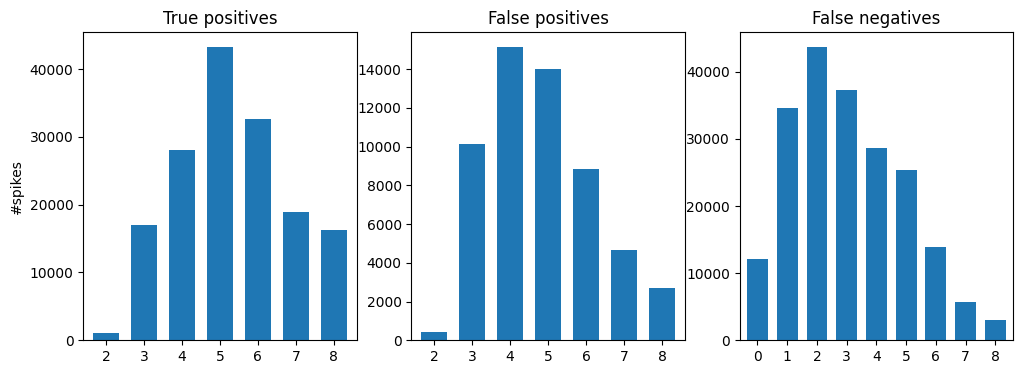

In [107]:
"""
For each metric, plot histograms for all:
    1. True positives (prop_and_ks_units)
    2. False positives (prop_only_units)
    3. False negatives (ks_only_units)
    
metrics: (elec, num_inner_loose_elecs, num_loose_elecs, fraction_loose_elecs, latency_diff, amp_median_diff, score)
"""
metric_idx = 1  # metric index in time_to_spike_match[time]
print("Num. inner loose electrodes")  

fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
              
plot.bar(true_positives, ax=a0)
plot.bar(false_positives, ax=a1)
plot.bar(false_negatives, ax=a2)

a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Num. loose elecs


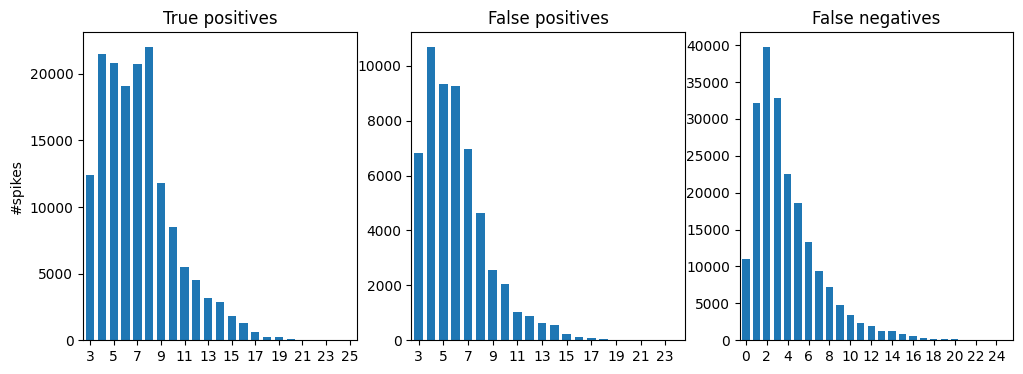

In [108]:
metric_idx = 2 
print(f"Num. loose elecs")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
plot.bar(true_positives, ax=a0)
plot.bar(false_positives, ax=a1)
plot.bar(false_negatives, ax=a2)

for ax in (a0, a1, a2):
    ax.set_xticks(ax.get_xticks()[::2])
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Percent loose elecs


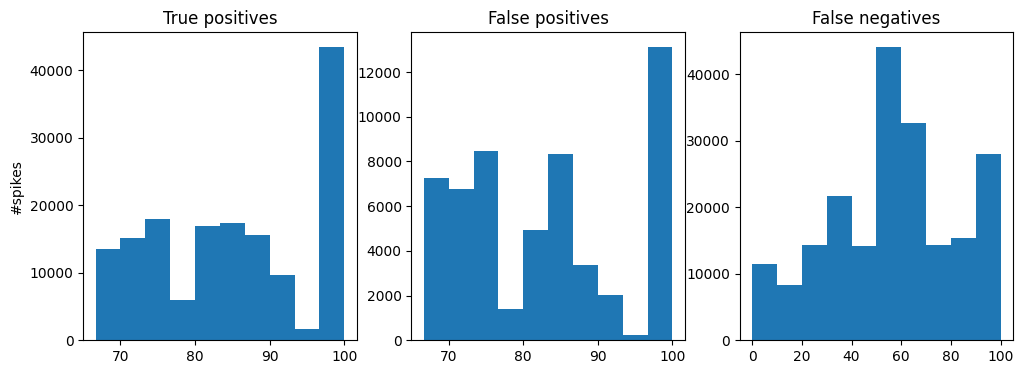

In [112]:
metric_idx = 3
print(f"Percent loose elecs")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 10}
plot.hist(np.array(true_positives)*100, axis=a0, **kwargs)
plot.hist(np.array(false_positives)*100, axis=a1, **kwargs)
plot.hist(np.array(false_negatives)*100, axis=a2, **kwargs)

# for ax in (a0, a1):
#     ax.set_xticks(ax.get_xticks()[::2])
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Latency difference


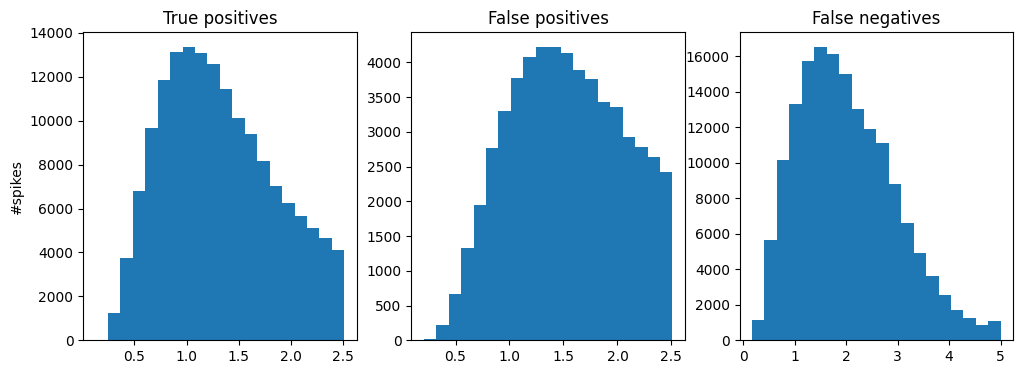

In [113]:
metric_idx = 4
print(f"Latency difference")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 20}
plot.hist(true_positives, axis=a0, **kwargs)
plot.hist(false_positives, axis=a1, **kwargs)
plot.hist(false_negatives, axis=a2, **kwargs)
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

Amplitude difference


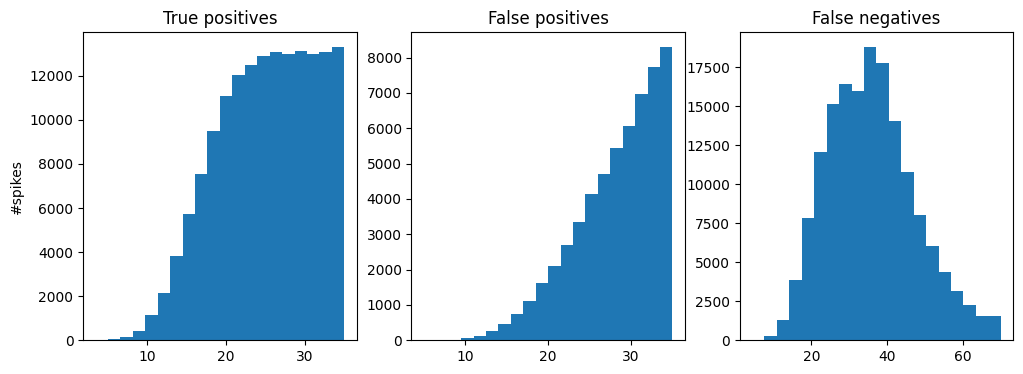

In [114]:
metric_idx = 5
print(f"Amplitude difference")
##
fig, (a0, a1, a2) = plt.subplots(1, 3, figsize=(12, 4))
true_positives, false_positives, false_negatives = F.get_tp_fp_fn(metric_idx, all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
         
kwargs = {"bins": 20}
plot.hist(np.array(true_positives)*100, axis=a0, **kwargs)
plot.hist(np.array(false_positives)*100, axis=a1, **kwargs)
plot.hist(np.array(false_negatives)*100, axis=a2, **kwargs)
    
a0.set_ylabel("#spikes")
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")

plt.show()

#### Scatter plots
metrics: (elec, num_inner_loose_elecs, num_loose_elecs, fraction_loose_elecs, latency_diff, amp_median_diff, score)

In [115]:
all_true_positives, all_false_positives, all_false_negatives = F.get_spike_metrics(all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)

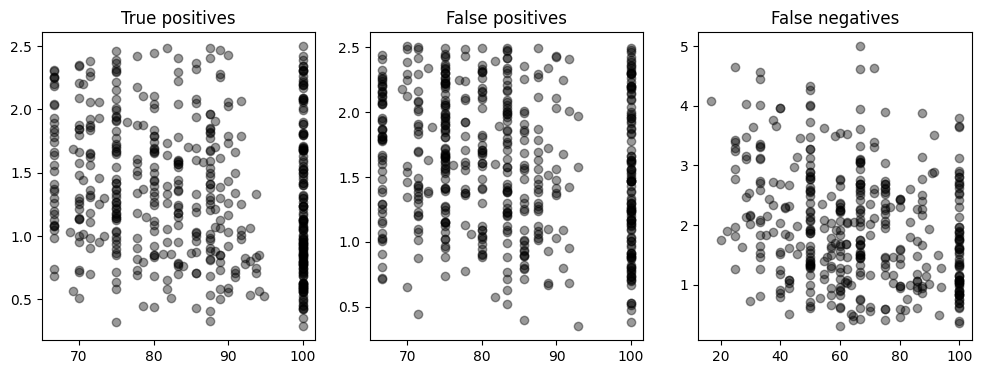

In [116]:
x_metric = 3  # fraction_loose_elecs 
y_metric = 4  # latency_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] * 100  # To make into percent
        y = metrics[y_metric]
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

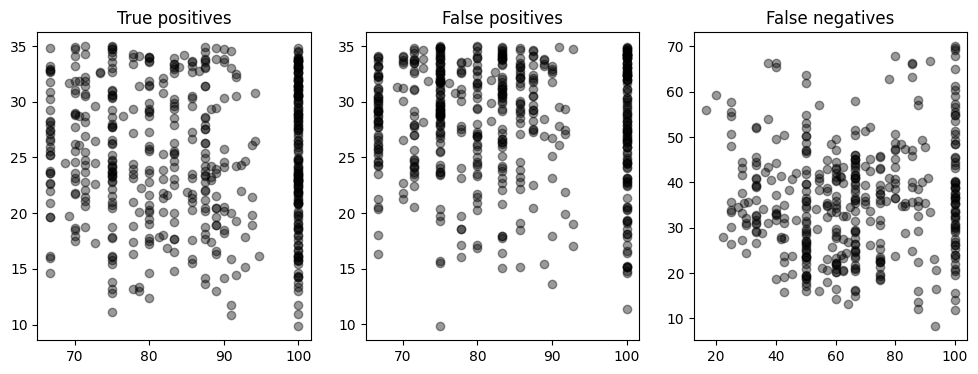

In [117]:
x_metric = 3  # fraction_loose_elecs 
y_metric = 5  # amp_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] * 100  # To make into percent
        y = metrics[y_metric] * 100  # To make into percent
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

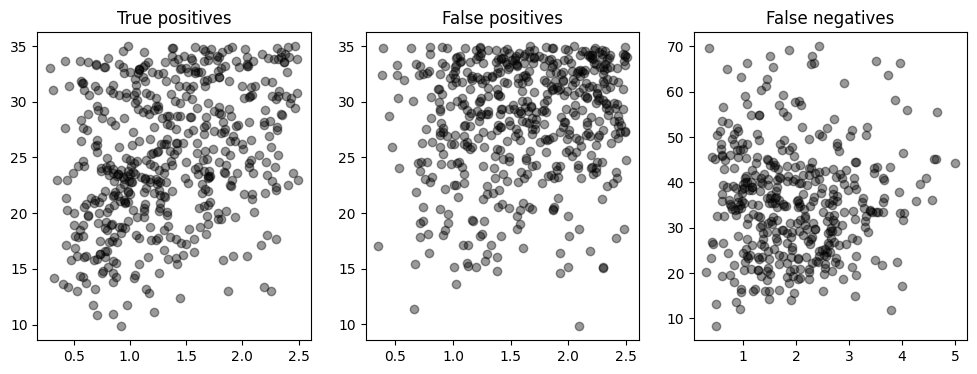

In [118]:
x_metric = 4  # latency_diff 
y_metric = 5  # amp_diff

num_spikes = 500  # for each subplot
##
np.random.seed(231)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, spikes in zip(axes, (all_true_positives, all_false_positives, all_false_negatives)):
    for idx in np.random.choice(len(spikes), num_spikes, replace=False):
        metrics = spikes[idx]
        x = metrics[x_metric] 
        y = metrics[y_metric] * 100  # To make into percent
        if np.isnan(x) or np.isnan(y):
            continue
        
        ax.scatter(x, y, color="black", alpha=0.4)
      
a0, a1, a2 = axes  
a0.set_title("True positives")
a1.set_title("False positives")
a2.set_title("False negatives")
plt.show()

#### Precision and recall after each spike assignment threshold

In [94]:
assert False, "This does not work because it does not account for the new false negatives caused by loosening thresholds"

PARAM_TESTS = (
    # (2, 3, 2/3, 2.51, 0.35),
    (-np.inf, -np.inf, -np.inf, np.inf, np.inf),
    # (-np.inf, 3, -np.inf, np.inf, np.inf),
    # (2, 3, -np.inf, np.inf, np.inf),
    # (2, 3, 2/3, np.inf, np.inf),
    # (2, 3, 2/3, 2.51, np.inf),
    # (2, 3, -np.inf, np.inf, 0.35)
    # (2, 3, 2/3, 2.51, 0.35),
    
    # (2, 3, -np.inf, 2.51, 0.35),
    # (2, 3, -np.inf, 4, 0.35), 
    # (2, 3, -np.inf, 2.51, 0.50), 
    # (2, 3, -np.inf, 4, 0.50), 
    # (2, 3, -np.inf, 5, 0.7), 
)
##
all_true_positives, all_false_positives, all_false_negatives = F.get_spike_metrics(all_ks_sequences, prop_and_ks_units, prop_only_units, ks_only_units)
for (min_inner_loose_detections, min_loose_detections_n, min_loose_detections_r, max_latency_diff, max_amp_median_diff) in PARAM_TESTS:
    num_tp = num_fp = num_fn = 0
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_true_positives:
        if num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_tp += 1
        else:
            num_fp += 1
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_false_positives:
        if num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_fp += 1
    for elec, num_inner_loose_elecs, num_loose_elecs, ratio_loose_elecs, latency_diff, amp_median_diff, score in all_false_negatives:
        if np.isnan(latency_diff):
            num_fn += 1
        elif num_inner_loose_elecs >= min_inner_loose_detections and \
            num_loose_elecs >= min_loose_detections_n and \
            ratio_loose_elecs >= min_loose_detections_r and \
            latency_diff <= max_latency_diff and \
            amp_median_diff <= max_amp_median_diff:
            num_tp += 1
        else:
            num_fn += 1
    
    print(f"{min_inner_loose_detections}_{min_loose_detections_n}_{min_loose_detections_r*100:.0f}%, {max_latency_diff} frames, {max_amp_median_diff}%")
    print(f"Precision: {num_tp / (num_tp+num_fp) *100:.1f}%")
    print(f"Recall: {num_tp / (num_tp + num_fn) *100:.1f}%")
    print()
    
    # Probably because of spike splitting, precision and recall when using correct thresholds are slightly difference

-inf_-inf_-inf%, inf frames, inf%
Precision: 84.9%
Recall: 87.1%



#### Footprints

--------------------------------------------------


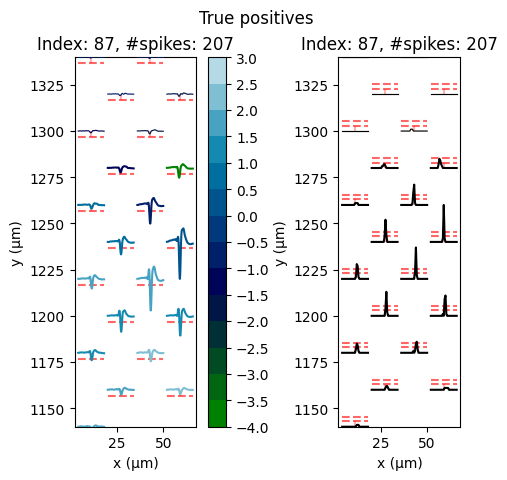

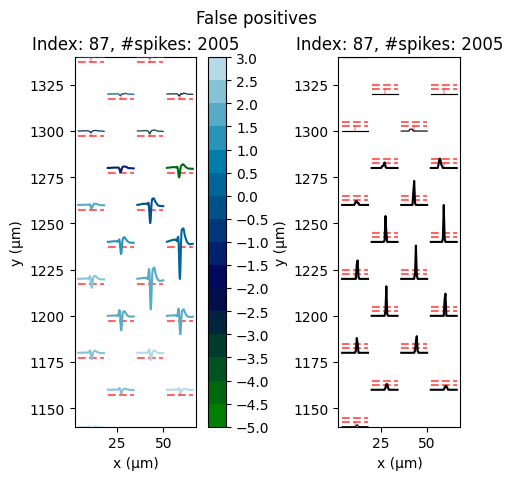

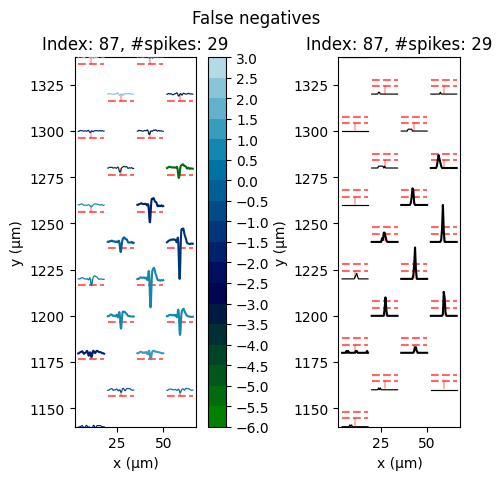

In [ ]:
num_units = 1
##
np.random.seed(231)
ind = np.random.choice(len(prop_and_ks_units), num_units)

# for prop_and_ks, prop_only, ks_only in zip(prop_and_ks_units, prop_only_units, ks_only_units):
for idx in ind:
    prop_and_ks, prop_only, ks_only = prop_and_ks_units[idx], prop_only_units[idx], ks_only_units[idx]
    print("-"*50)
    
    F.plot_elec_probs(prop_and_ks)
    plt.suptitle("True positives")
    plt.show()
    
    F.plot_elec_probs(prop_only)
    plt.suptitle("False positives")
    plt.show()
    
    F.plot_elec_probs(ks_only)
    plt.suptitle("False negatives")
    plt.show()

#### Save footprints

In [122]:
SAVE_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231230/footprints")

In [123]:
for prop_and_ks, prop_only, ks_only in zip(tqdm(prop_and_ks_units), prop_only_units, ks_only_units):
    # For testing
    # idx = 44
    # prop_and_ks, prop_only, ks_only = prop_and_ks_units[idx], prop_only_units[idx], ks_only_units[idx]

    save_path = SAVE_ROOT / str(prop_and_ks.idx)
    save_path.mkdir(parents=True, exist_ok=True)

    if len(prop_and_ks.spike_train) > 0:
        F.plot_elec_probs(prop_and_ks)
        plt.suptitle("True positives")
        plt.savefig(save_path / "true_positives.jpg", format="jpg")
        plt.close()

    if len(prop_only.spike_train) > 0:
        F.plot_elec_probs(prop_only)
        plt.suptitle("False positives")
        plt.savefig(save_path / "false_positives.jpg", format="jpg")
        plt.close()

    if len(ks_only.spike_train) > 0:
        F.plot_elec_probs(ks_only)
        plt.suptitle("False negatives")
        plt.savefig(save_path / "false_negatives.jpg", format="jpg")
        plt.close()

  0%|          | 0/211 [00:00<?, ?it/s]

100%|██████████| 211/211 [10:46<00:00,  3.06s/it]


### Development

##### 12/29/23 - Why so many spikes missed by RT-Sort?

In [71]:
IDX = 1
OVERLAP_TIME = 0.4

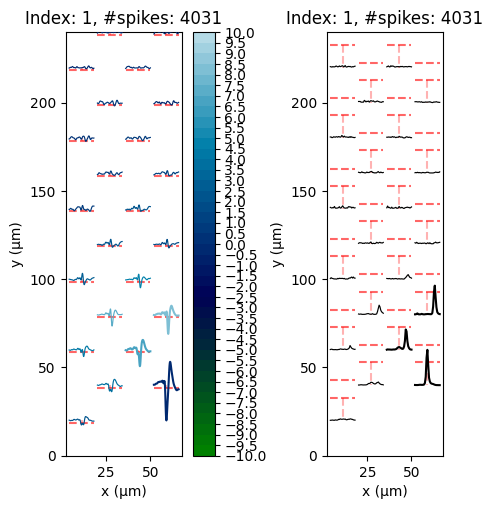

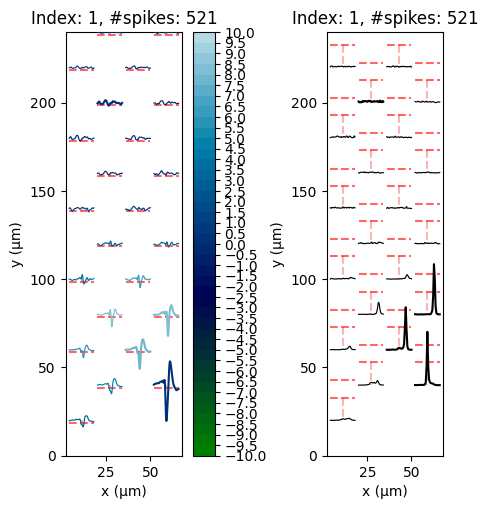

In [72]:
ks_unit = all_ks_units[IDX]
prop_unit = all_prop_units[IDX]
## 
amp_kwargs, prob_kwargs = F.plot_elec_probs(ks_unit)
plt.show()
F.plot_elec_probs(prop_unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.show()

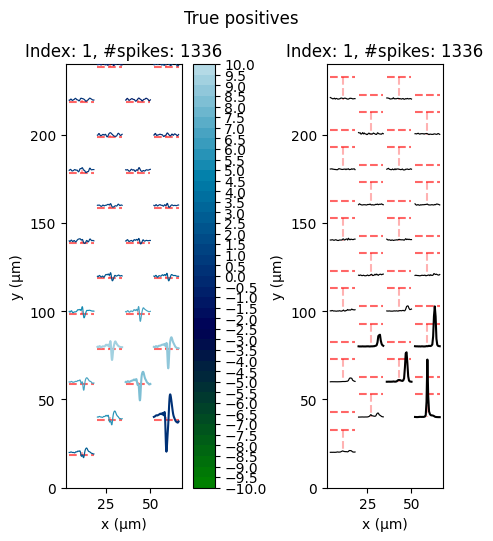

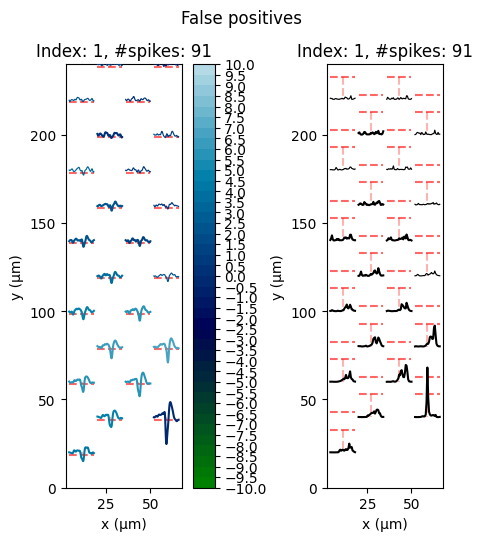

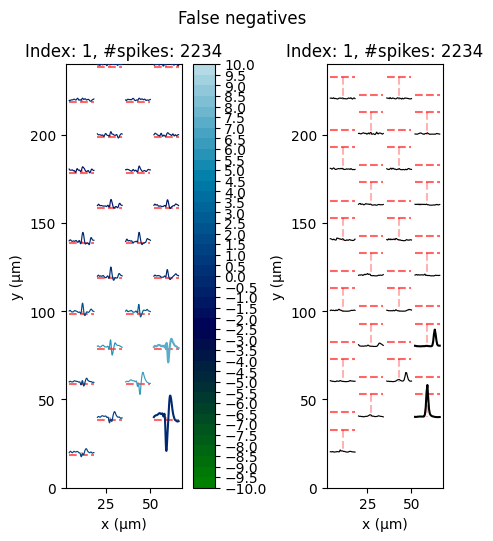

In [20]:
F.plot_elec_probs(prop_and_ks_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("True positives")
plt.show()

F.plot_elec_probs(prop_only_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("False positives")
plt.show()

F.plot_elec_probs(ks_only_units[IDX], amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
plt.suptitle("False negatives")
plt.show()

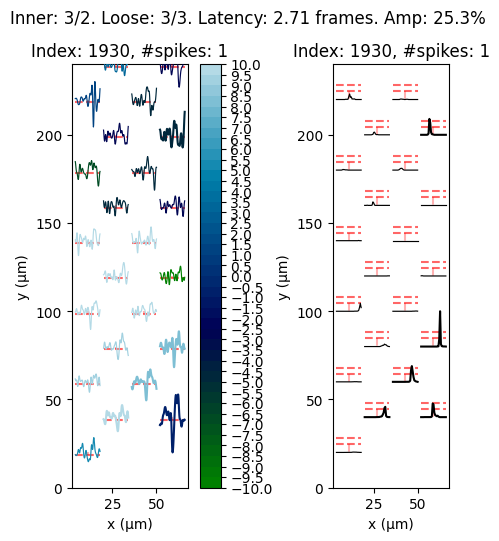

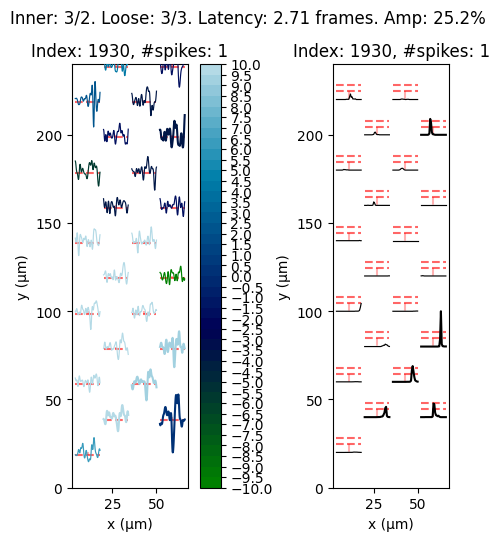

In [136]:
SPIKE_IDX = 1930
##
time = ks_only_units[IDX].spike_train[SPIKE_IDX]
F.plot_seq_spike_overlap(seq, time, SPIKE_IDX)
plt.show()

F.plot_seq_spike_overlap(seq, 207257.033333, SPIKE_IDX)
plt.show()


In [ ]:
F.assign_spikes([deepcopy(seq)], TRAINING_MS,
                interelec=True, only_max_amps=False,
                verbose=True)

In [125]:
test = F.setup_cluster(deepcopy(all_ks_sequences[1]))
test = np.sort(test)
print(np.mean(test))
print(np.mean(test[round(0.2*len(test)):-round(0.2*len(test))]))
print(np.median(test))

0.10014746770508275
0.02079222851897385
0.007289761388122044


In [84]:
all_ks_sequences[1].comp_elecs

[1, 2, 3, 4, 5, 6, 7, 9]

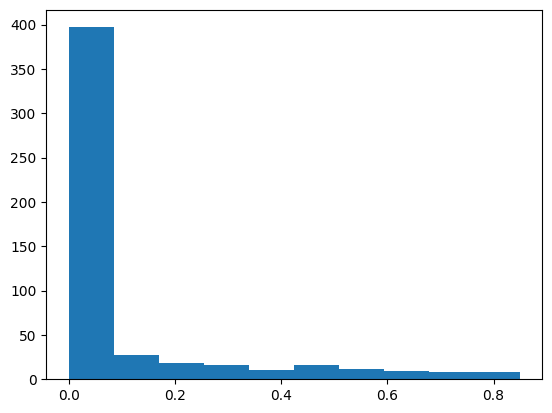

In [81]:
plt.hist(test)
plt.show()

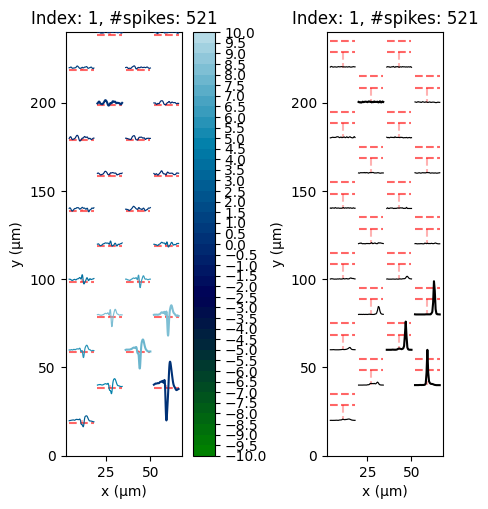

In [93]:
F.plot_elec_probs(seq)
plt.show()

In [106]:
seq.comp_elecs

[1, 2, 3, 4, 5, 6, 7, 9]

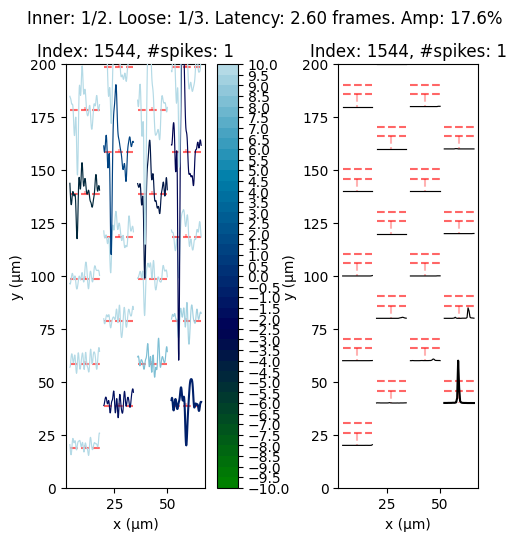

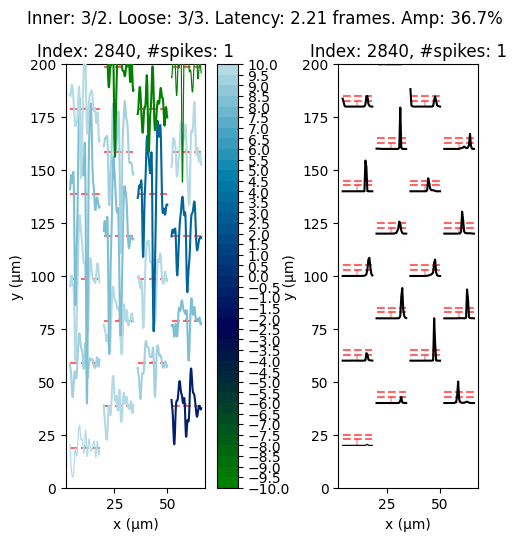

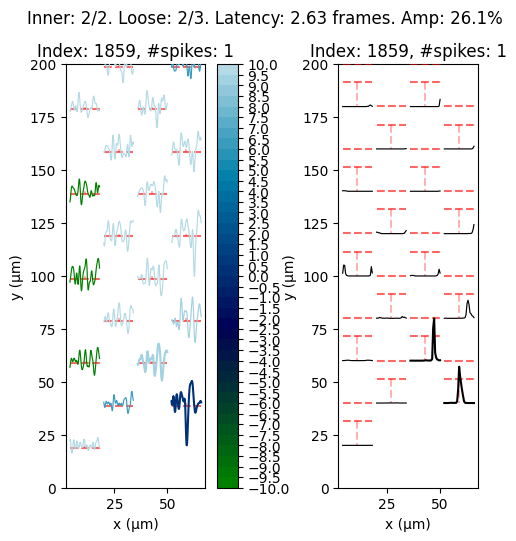

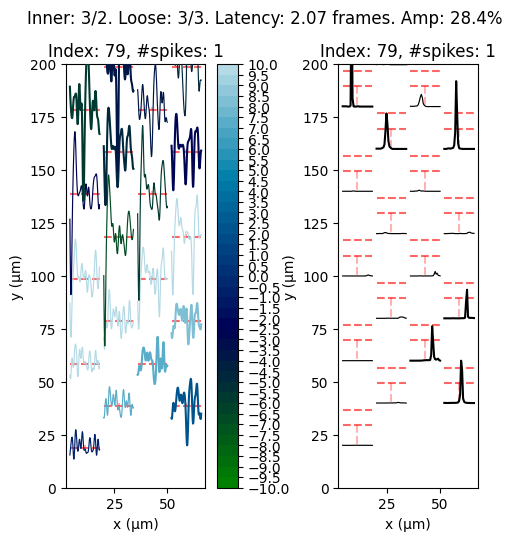

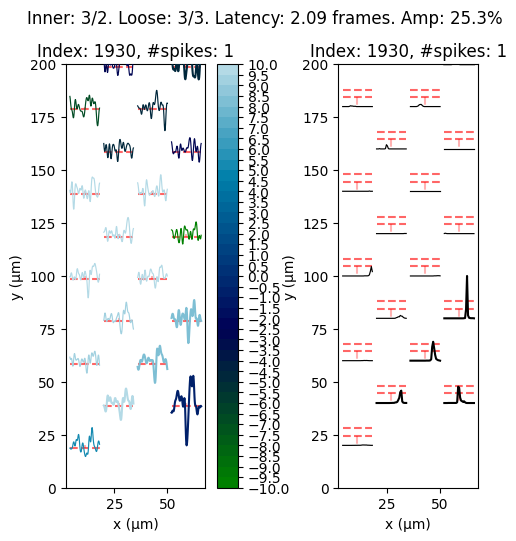

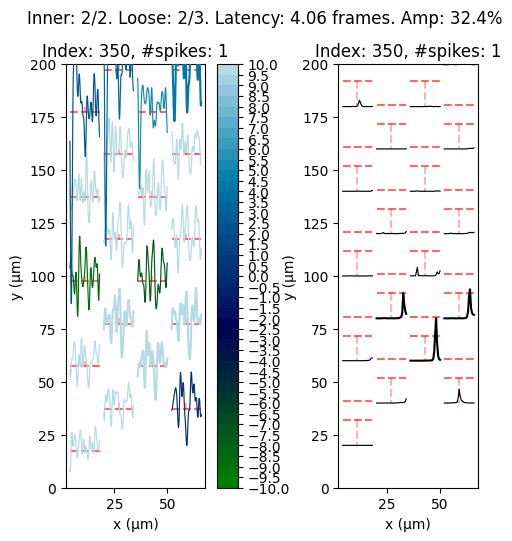

In [ ]:
np.random.seed(100)

seq = all_ks_sequences[IDX]
ks_only = ks_only_units[IDX]

for idx in np.random.choice(len(ks_only.spike_train), 6):
    time = ks_only.spike_train[idx]
    F.plot_seq_spike_overlap(seq, time, idx)
    plt.show()

In [ ]:
seq = all_ks_sequences[IDX]

latency_diffs = []
amp_median_diffs = []
for time in tqdm(ks_only_units[IDX].spike_train):
    latency_diff, amp_median_diff = F.get_seq_spike_overlap(seq, time)
    latency_diffs.append(latency_diff)
    amp_median_diffs.append(amp_median_diff)

100%|██████████| 3336/3336 [00:14<00:00, 229.64it/s]


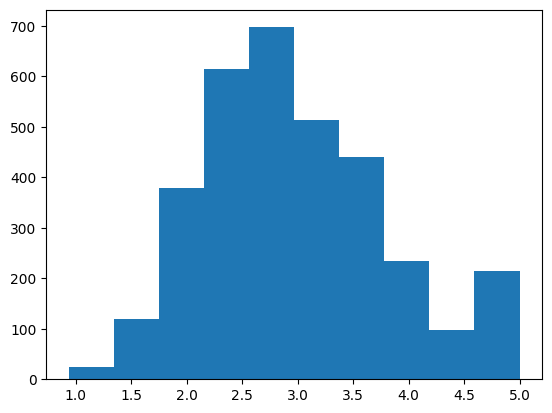

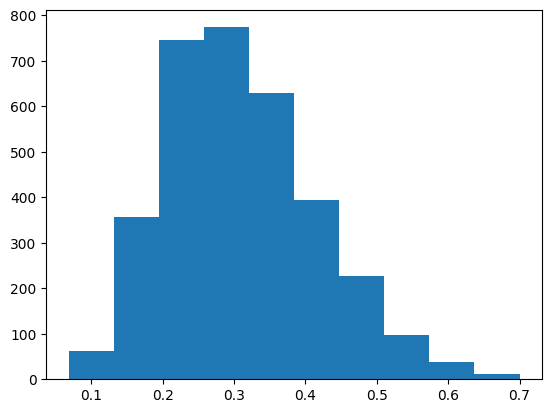

In [ ]:
plt.hist(latency_diffs)
plt.show()
plt.hist(amp_median_diffs)
plt.show()

In [ ]:
sequence = all_ks_sequences[IDX]
count = 0
for spike in ks_unit.spike_train:
    if spike in sequence.time_to_spike_match:
        count += 1
# true_positives, false_positives, false_negatives = Comparison.get_matching_events(ks_unit.spike_train, prop_unit.spike_train)
detectable_times = list(sequence.time_to_spike_match.keys())  # All spikes that can be detected by RT-Sort (detected on at least two elecs by DL model)
detectable_times = np.sort(detectable_times)

# Get ks's closest spike match in time_to_spike_match (upper bound of #matches, i.e. only requirement is DL model detecting on at least two elecs)
max_num_matches = 0  
for ks_spike in ks_unit.spike_train:
    _, prop_spike = utils.find_closest(detectable_times, ks_spike)
    if np.abs(prop_spike - ks_spike) <= OVERLAP_TIME:
        max_num_matches += 1
print(f"Maximum #matches: {max_num_matches}")

Maximum #matches: 2761


In [ ]:
print(f"All stringnet + >=1 loose DL detections:", len(detectable_times))

All stringnet + >=1 loose DL detections: 10829


## Consistent spikes
Save footprints of matching, RT-Sort only spikes, other sorter spikes using data from consistent_spikes.ipynb

In [55]:
ROOT_PATH = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/rt_sort/240319/consistent_spikes/prop_delay_0.5ms/snr_preceeding_50ms")
SORTER_PATHS = [
    # ROOT_PATH / "kilosort2.npy",
    ROOT_PATH / "herdingspikes.npy",
    ROOT_PATH / "ironclust.npy",
    ROOT_PATH / "tridesclous.npy",
    ROOT_PATH / "spykingcircus.npy",
    ROOT_PATH / "hdsort.npy"
]
SORTER_NAMES = [  # Used in plots
    # "Kilosort2",
    "HerdingSpikes2",
    "IronClust",
    "Tridesclous",
    "SpyKING Circus",
    "HDSort"
]
SAVE_ROOT = ROOT_PATH / "footprints"

In [60]:
def job(task):
    """
    m = matching
    r = RT-Sort
    o = other
    """    
    
    unit_idx, save_dir = task
    sorter=SORTER
    sorter_name=SORTER_NAME

    chans_rms = np.full(NUM_ELECS, 1)
    unit_data = sorter[unit_idx]

    fig, axes = plt.subplots(ncols=3, figsize=(2.3*3, 5.5))
    m_ax, r_ax, o_ax = axes

    rt_unit=Unit(unit_data['idx'], [spike['time'] for spike in unit_data['matching_spikes']] + [spike['time'] for spike in unit_data['rt_sort_only_spikes']], unit_data["root_elec"], RECORDING)
    # _, wf_widths, _ = F.plot_elec_probs(rt_unit, return_wf_data=True)

    m_unit=Unit(unit_data['idx'], [spike['time'] for spike in unit_data['matching_spikes']], unit_data["root_elec"], RECORDING)
    m_temps, _, m_wf_colors = F.plot_elec_probs(m_unit, return_wf_data=True, num_spikes=None)
    r_unit=Unit(unit_data['idx'], [spike['time'] for spike in unit_data['rt_sort_only_spikes']], unit_data["root_elec"], RECORDING)
    r_temps, _, r_wf_colors = F.plot_elec_probs(r_unit, return_wf_data=True, num_spikes=None)
    o_unit=Unit(unit_data['idx'], [spike['time'] for spike in unit_data['other_sorter_only_spikes']], unit_data["root_elec"], RECORDING)
    o_temps, _, o_wf_colors = F.plot_elec_probs(o_unit, return_wf_data=True, correct_spike_time_offset=True, num_spikes=None)
    
    # Determine waveform widths
    root_width=2.75
    pass_width=1.5
    not_pass_width=0.85
    wf_widths = []  
    loose_elecs = set(unit_data['loose_elecs'])
    for elec in range(NUM_ELECS):
        if elec == unit_data['root_elec']:
            wf_widths.append(root_width)
        elif elec in loose_elecs:
            wf_widths.append(pass_width)
        else:
            wf_widths.append(not_pass_width)
        
    # Determine color bar limits
    color_elecs = unit_data['loose_elecs']  # Elecs used to determine color bar limits
    min_c = np.inf
    max_c = -np.inf
    for colors in (m_wf_colors, r_wf_colors, o_wf_colors):
        if np.all(np.isnan(colors)):
            continue
        colors = [colors[elec] for elec in color_elecs]
        min_c = min(min_c, round(np.floor(np.min(colors))) - 1)
        max_c = max(max_c, round(np.ceil(np.max(colors))) + 1)
    
    amp_kwargs = m_unit.plot(axis=m_ax, wf=m_temps, wf_widths=wf_widths, wf_colors=m_wf_colors, fig=fig, mea=False,
                             chans_rms=chans_rms, min_c=min_c, max_c=max_c,
                             colorbar_location="left", use_colorbar_label=False)
    r_unit.plot(axis=r_ax, wf=r_temps, wf_widths=wf_widths, wf_colors=r_wf_colors, fig=None, mea=False,
                **amp_kwargs)
    o_unit.plot(axis=o_ax, wf=o_temps, wf_widths=wf_widths, wf_colors=o_wf_colors, fig=None, mea=False,
                **amp_kwargs)

    # m_ax.set_title("Matching")
    # r_ax.set_title("RT-Sort only")
    # o_ax.set_title(f"{sorter_name} only")
    
    for ax in axes:        
        ax.set_title("")
        ax.set_xlabel("")
        ax.set_xticks([])
        ax.set_ylabel("")
        ax.set_yticks([])

        # Hide top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Increase thickness of the bottom and left spines
        ax.spines["bottom"].set_linewidth(2.5)
        ax.spines["left"].set_linewidth(2.5)

        # Increase thickness of tick marks
        ax.tick_params(axis='both', direction='out', length=6, width=2.5, colors='black')

    # plt.savefig(save_dir / f"{unit_data['idx']}.jpg", format="jpg")  # jpg
    # save_dir = Path("/data/MEAprojects/dandi/000034/sub-mouse412804")  # For testing
    plt.savefig(save_dir / f"{unit_data['idx']}.svg", format="svg")  # svg
    plt.close()
    
    # # Testing 
    # r_ax.set_title(f"Seq {unit_data['idx']}")
    # plt.show()
    
    # Sanity check, compare means of spikes with footprints
    # means = np.array([spike['elecs'] for spike in unit_data['other_sorter_only_spikes']])
    # means = np.mean(means, axis=0)
    # print(means[:5])

# Testing 
unit_id = 76
sorter = np.load(ROOT_PATH/"spykingcircus.npy", allow_pickle=True)
unit_saved_idx = [unit["idx"] for unit in sorter].index(unit_id)

SORTER = sorter
SORTER_NAME = "Other Sorter"
job((unit_saved_idx, None))
    
# np.seterr("ignore")  # RuntimeWarning: invalid value encountered in true_divide ret, rcount, out=ret, casting='unsafe', subok=False) # Mean of empty slice warning is when matching, RT-Sort only, or other only have no spikes
# for sorter_path, SORTER_NAME in zip(SORTER_PATHS, SORTER_NAMES):
#     print(SORTER_NAME)
#     SORTER = np.load(sorter_path, allow_pickle=True)
#     save_dir = SAVE_ROOT / sorter_path.name.split(".")[0]
#     save_dir.mkdir(parents=True, exist_ok=True)
#     tasks = [(unit_idx, save_dir) for unit_idx in range(len(SORTER))]
#     with Pool(processes=16) as pool:
#         for _ in tqdm(pool.imap_unordered(job, tasks), total=len(tasks)):
#             pass
# np.seterr('raise')

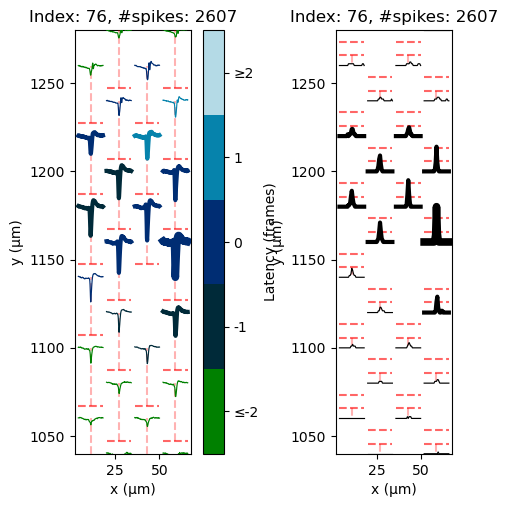

In [51]:
F.plot_elec_probs(trained_sequences[76], num_spikes=None)
plt.show()

In [43]:
test = deepcopy(trained_sequences[76])
F.setup_cluster(test)
len(test.loose_elecs)

9

0.1493
0.06976


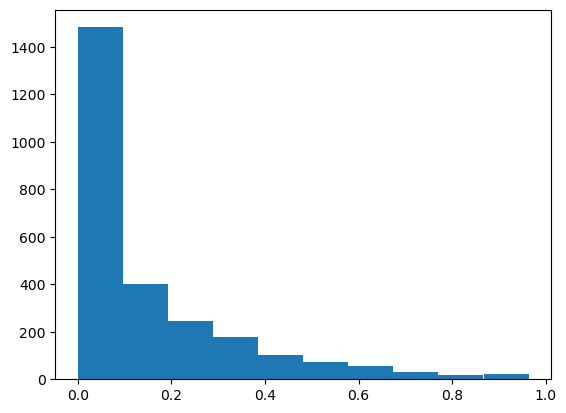

In [46]:
test = trained_sequences[76].every_elec_prob[86]
print(np.mean(test))
print(np.median(test))
plt.hist(test)
plt.show()

In [34]:
unit_data = sorter[unit_saved_idx]
ELEC_LOCS[unit_data['root_elec']]

array([  59., 1160.])

In [33]:
for idx in sorter[unit_saved_idx]["loose_elecs"]:
    print(ELEC_LOCS[idx])

[  59. 1120.]
[  59. 1160.]
[  27. 1160.]
[  43. 1180.]
[  11. 1180.]
[  59. 1200.]
[  27. 1200.]
[  43. 1220.]
[  11. 1220.]


In [ ]:
seq = None
for seq in tested_sequences:
    if seq.idx == unit_id:
        break
else:
    assert False, "Seq not found"
print(seq.idx)
print(seq.spike_train)

In [38]:
F.plot_elec_probs(seq)
plt.show()

In [41]:
unit_data = SORTER[unit_saved_idx]
# # Training ms
# for elec in unit_data['inner_loose_elecs']:
#     print(f"{ELEC_LOCS[elec]}: {unit_data['means'][elec]}")

# Testing ms
latencies = []
amplitudes = []
for name in ("matching_spikes", "rt_sort_only_spikes"):
    for spike_data in unit_data[name]:
        latencies.append(spike_data["elecs"][:, 0])
        amplitudes.append(spike_data["elecs"][:, 1])
mean_latencies = np.mean(latencies, axis=0)
mean_amplitudes = np.mean(amplitudes, axis=0)
    
for elec in unit_data['inner_loose_elecs']:
    print(f"{ELEC_LOCS[elec]}: {mean_latencies[elec]}, {mean_amplitudes[elec]}")

[ 43. 980.]: 0.0, 5.654795771059782
[ 11. 980.]: 0.6123188405797102, 3.702774711277174
[  59. 1000.]: -0.3007246376811594, 6.355574898097826
[  27. 1000.]: -0.2898550724637681, 15.266311424365941
[  43. 1020.]: -1.6594202898550725, 9.946798573369565


In [36]:
seq.all_latencies[seq.inner_loose_elecs]

array([ 0.        ,  0.01587302, -2.58730159, -0.28571429, -4.36507937])

In [37]:
seq.inner_loose_elecs

[70, 71, 72, 73, 74]